## **I. Préparation de l'environnement**

In [1]:
!pip install ultralytics
!pip install transformers
!pip install PytorchWildlife
!pip install imgaug
!pip install hachoir
!pip install dill
!pip install timm
!pip install onnx
!pip install onnxruntime
!pip install streamlit
!pip install numpy==1.23.5  # Or another compatible version if needed
# !pip uninstall -y torchvision
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
print(np.__version__)

1.23.5


In [ ]:
# Général
from tqdm import tqdm
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import itertools
import requests
from collections import Counter, defaultdict
import gc

# Traitement d'image
import cv2
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import imgaug.augmenters as iaa

# Pytorch
import torch
import torch.optim as optim
from torch.amp import GradScaler, autocast
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms
# import onnxruntime


# IA
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import timm
# from PytorchWildlife.models import detection as pw_detection
# from PytorchWildlife.models import classification as pw_classification
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
# import streamlit as st
import wandb

In [ ]:
%matplotlib inline

In [ ]:
wandb.login()

wandb: Currently logged in as: eliot-jacquemin-soia2025 (eliot-jacquemin-soia2025-ensta-bretagne) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### **I.1 DeepFaune : détecteur**

In [ ]:
!unzip testDeepFaune.zip

unzip:  cannot find or open testDeepFaune.zip, testDeepFaune.zip.zip or testDeepFaune.zip.ZIP.


Ici on extrait le détecteur qui a été utilisé par DeepFaune dans sa première version. Il s'agit du MegaDetectorV5 développé par Pytorch Wildlife. Il permet de détecter des animaux, être humaines et voitures en utilisant YOLOv5 avec un performance très satisfaisante. Cette précision dans sa détection semble être largement suffisante pour notre cas d'utilisation. Bien qu'un YOLO est généralement capable de classer les objets détectés, ici nous n'utiliserons que la partie détection.

In [ ]:
# Extraction du model de détection
detection_model = pw_detection.MegaDetectorV5()

Downloading: "https://zenodo.org/records/13357337/files/md_v5a.0.0.pt?download=1" to /root/.cache/torch/hub/checkpoints/md_v5a.0.0.pt
100%|██████████| 268M/268M [02:27<00:00, 1.91MB/s]
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


In [ ]:
detection_result

{'img_id': 'None',
 'detections': Detections(xyxy=array([[        170,         226,         916,         847],
        [        636,         587,        1264,         966]], dtype=float32), mask=None, confidence=array([    0.92741,     0.55973], dtype=float32), class_id=array([0, 0]), tracker_id=None, data={}),
 'labels': ['animal 0.93', 'animal 0.56']}

On peut voir ci-dessus le résultat classique ***detection_result*** que renvoit une prédiction de détection du MGDV5. Sous forme de dictionnaire, nous avons accès aux bounding boxes détectées (s'il y'en a), ainsi qu'au prédiction faites avec leur score de confiance...


Ci-dessous, on affiche le résultat qu'on pourrait classiquement avoir en utilisant MGDV5. On peut noter la perforamnce du modèle à être capable de détecter certains animaux dans des conditions particulièrement difficiles, dues notamment à des occlusions ou des conditions extérieures compliquées.

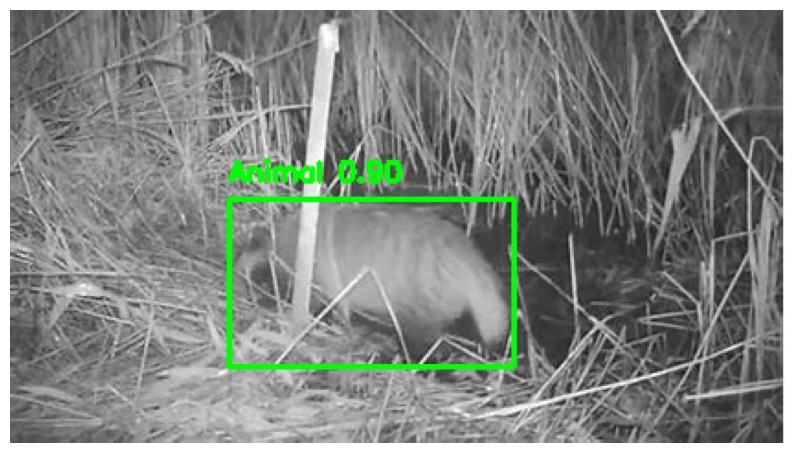

In [ ]:
# Charger l'image originale
img = Image.open('/content/testDeepFaune/OIP (10).jpg')
img_cv = np.array(img)  # Convertir en tableau numpy (format OpenCV)

# Convertir PIL -> OpenCV (RGB -> BGR)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

# Récupérer les détections
detections = detection_result["detections"]

# Dessiner les bounding boxes
for i in range(len(detections.xyxy)):
    x1, y1, x2, y2 = map(int, detections.xyxy[i])  # Coordonnées (converties en entiers)
    confidence = detections.confidence[i]  # Score de confiance
    label = f"Animal {confidence:.2f}"  # Texte à afficher

    # Dessiner le rectangle
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vert, épaisseur 2

    # Ajouter le texte
    cv2.putText(img_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convertir OpenCV (BGR -> RGB) pour affichage avec Matplotlib
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Afficher l'image avec les détections
plt.figure(figsize=(10, 6))
plt.imshow(img_cv)
plt.axis("off")  # Cacher les axes
plt.show(block=True)  # 🔹 Ajout de plt.show() pour forcer l'affichage


### **I.2 DeepFaune : classifieur**

In [ ]:
!unzip vit.zip

Archive:  vit.zip
   creating: vit/
  inflating: vit/deepfaune-vit_large_patch14_dinov2.lvd142m.v3.pt  


Ici on extrait le classifieur ViT utilisant Dinov2 de DeepFaune. Une fois les bounding boxes extraites par le détecteur, celles-ci sont rognées hors de l'image et traitées une par une par le classifieur.

Actuellement, 34 classes sont présentes dans ce classifieur. Hors dans notre contexte, beaucoup moins de classes sont nécessaires. Il faudra donc fine-tuner notre modèle après avoir modifié la taille de couche finale du ViT pré-entraîné.

In [ ]:
# Initialiser le TPU
# device = xm.xla_device()

# Charger les poids du modèle (sans les mettre sur GPU)
weights_path = "/content/vit/deepfaune-vit_large_patch14_dinov2.lvd142m.v3.pt"
checkpoint = torch.load(weights_path, map_location="cuda")

# Extraire les poids
state_dict = checkpoint["state_dict"]


In [ ]:
# prompt: vider gpu

import torch

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
    # Empty GPU cache
    torch.cuda.empty_cache()
    print("GPU cache cleared.")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU.")


Using CUDA
GPU cache cleared.


In [ ]:
classification_model = timm.create_model("vit_large_patch14_dinov2.lvd142m", pretrained=False, num_classes=34)  # Ajuste num_classes si nécessaire


In [ ]:
classification_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

In [ ]:
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("base_model.", "")  # Supprimer le préfixe 'base_model.'
    new_state_dict[new_key] = value

# Charger les poids en ignorant uniquement les erreurs dues à une shape différente
classification_model.load_state_dict(new_state_dict)


<All keys matched successfully>

In [ ]:
classification_model.head = nn.Sequential(
    nn.Linear(classification_model.num_features, 6),
    nn.Softmax(dim=1)  # Softmax sur la dimension des classes
)

AttributeError: 'DeepfauneClassifier' object has no attribute 'num_features'

In [ ]:
print(state_dict.keys())


odict_keys(['base_model.cls_token', 'base_model.pos_embed', 'base_model.patch_embed.proj.weight', 'base_model.patch_embed.proj.bias', 'base_model.blocks.0.norm1.weight', 'base_model.blocks.0.norm1.bias', 'base_model.blocks.0.attn.qkv.weight', 'base_model.blocks.0.attn.qkv.bias', 'base_model.blocks.0.attn.proj.weight', 'base_model.blocks.0.attn.proj.bias', 'base_model.blocks.0.ls1.gamma', 'base_model.blocks.0.norm2.weight', 'base_model.blocks.0.norm2.bias', 'base_model.blocks.0.mlp.fc1.weight', 'base_model.blocks.0.mlp.fc1.bias', 'base_model.blocks.0.mlp.fc2.weight', 'base_model.blocks.0.mlp.fc2.bias', 'base_model.blocks.0.ls2.gamma', 'base_model.blocks.1.norm1.weight', 'base_model.blocks.1.norm1.bias', 'base_model.blocks.1.attn.qkv.weight', 'base_model.blocks.1.attn.qkv.bias', 'base_model.blocks.1.attn.proj.weight', 'base_model.blocks.1.attn.proj.bias', 'base_model.blocks.1.ls1.gamma', 'base_model.blocks.1.norm2.weight', 'base_model.blocks.1.norm2.bias', 'base_model.blocks.1.mlp.fc1.we

In [ ]:
print(state_dict["base_model.head.weight"].shape)  # Devrait être [3, 1024]

torch.Size([34, 1024])


In [ ]:
# Charger l'image pour la classification
img_class = Image.open('/content/blaireau_ou_herisson.jpg')

# Transformation de l'image
transform_class = transforms.Compose([
    transforms.Resize((518, 518)),  # Redimensionnement pour le modèle ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform_class(img_class).unsqueeze(0)

# Déplacer l'image vers le bon device (CPU dans ce cas)
input_tensor = input_tensor.to("cpu")

# Classification de l'image
with torch.no_grad():
    classification_output = classification_model(input_tensor)

# Obtenir les probabilités
probabilities = torch.nn.functional.softmax(classification_output[0], dim=0)


# Trouver la classe la plus probable
predicted_class_index = torch.argmax(probabilities)

# Afficher la prédiction
print(f"Predicted class index : {predicted_class_index}")
print(f"Probabilities : {probabilities}")

# Charger les noms des classes (si disponible)
# Assurez-vous d'avoir un fichier 'class_names.txt' avec un nom de classe par ligne
# try:
#     with open("class_names.txt", "r") as f:
#         class_names = [line.strip() for line in f.readlines()]

#     # Afficher le nom de la classe prédite
#     predicted_class_name = class_names[predicted_class_index]
#     print(f"Predicted class name: {predicted_class_name}")

# except FileNotFoundError:
#     print("File 'class_names.txt' not found.")


Predicted class index : 1
Probabilities : tensor([0.01282, 0.62830, 0.01061, 0.00446, 0.01384, 0.00148, 0.00281, 0.00107, 0.00255, 0.00313, 0.00974, 0.03350, 0.00164, 0.00485, 0.00830, 0.00348, 0.03386, 0.01242, 0.00171, 0.00434, 0.01526, 0.00805, 0.00170, 0.10265, 0.00237, 0.01255, 0.00652, 0.00386, 0.00129, 0.01992, 0.00900, 0.00177, 0.00102, 0.01913])


In [ ]:
loaded_params = 0
total_params = 0

for name, param in classification_model.named_parameters():
    if name in new_state_dict:
        loaded_params += param.numel()
    total_params += param.numel()

percentage_loaded = (loaded_params / total_params) * 100
print(f"Poids chargés : {percentage_loaded:.2f}%")


Poids chargés : 100.00%


In [ ]:
print(checkpoint.keys())

dict_keys(['args', 'state_dict', 'transform'])


### **I.3 Pipeline de traitement d'images avec DeepFaune**

In [ ]:
!unzip testDeepFaune.zip

Archive:  testDeepFaune.zip
   creating: testDeepFaune/
  inflating: testDeepFaune/blaireau_ou_herisson.jpg  
  inflating: testDeepFaune/OIP (1).jpg  
  inflating: testDeepFaune/OIP (10).jpg  
  inflating: testDeepFaune/OIP (12).jpg  
  inflating: testDeepFaune/OIP (2).jpg  
  inflating: testDeepFaune/OIP (3).jpg  
  inflating: testDeepFaune/OIP (4).jpg  
  inflating: testDeepFaune/OIP (5).jpg  
  inflating: testDeepFaune/OIP (6).jpg  
  inflating: testDeepFaune/OIP (7).jpg  
  inflating: testDeepFaune/OIP (8).jpg  
  inflating: testDeepFaune/OIP (9) copie.jpg  
  inflating: testDeepFaune/OIP (9).jpg  
  inflating: testDeepFaune/OIP.jpg   
  inflating: testDeepFaune/OIP_copie.jpg  
  inflating: testDeepFaune/télécharger (1).jpg  
  inflating: testDeepFaune/télécharger (2).jpg  
  inflating: testDeepFaune/télécharger.jpg  


In [ ]:
!unzip test_images.zip

Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/184313.jpg  
  inflating: test_images/9dbfa52449_50036562_mustela-nivalis-british-wildlife-centre-4.jpg  
  inflating: test_images/A-cervus-near-the-woods..jpg  
  inflating: test_images/DSC2028.jpg  
  inflating: test_images/faire-fuir-belette (1).jpg  
  inflating: test_images/herisson-cage_1308-141971.jpg  
  inflating: test_images/Herisson-Fotolia.jpg  
  inflating: test_images/loutre-d-europe_1071_5_orig.jpg  
  inflating: test_images/martre-amerique-013.jpg  
  inflating: test_images/mo8milu0eae.jpg  
  inflating: test_images/OIP (1).jpg  
  inflating: test_images/OIP (2).jpg  
  inflating: test_images/OIP (3).jpg  
  inflating: test_images/OIP.jpg     
  inflating: test_images/R (1).jpg   
  inflating: test_images/R (2).jpg   
  inflating: test_images/R.jpg       
  inflating: test_images/R.png       


In [ ]:
!unzip fox_images.zip

Archive:  fox_images.zip
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/10PSL8T23UZC.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/2AUNLDRG3BWP.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/2TR6JZF204SA.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/3O5MAZZVB9JC.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/3TMR10IVT67Y.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/444S9RVW0IZS.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/45HWY27DGR9Y.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/55BTPD5Z8DLM.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/55ELPUKUL7V7.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/5LF5WQPXC3LC.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/5O2JASKUJ8C9.jpg  
  inflating: images.cv_8rk8h3aklzqjr2tcx

La fonction ***DeepFauneBatch*** a été développé dans le but de créer une pipeline de traitement des images collectées, afin d'afficher en sortie le décompte du nombre d'animaux par espèce détécté dans un fichier donné. Comme décris plus haut, pour une image donnée en entrée, le detecteur détecte les animaux présents. Puis, pour chaque bounding box, on applique le classifieur sur cette partie rognée de l'image.

In [ ]:
def DeepFauneBatch(folder_path, detection_model, classification_model, device):
    classification_model.eval().to(device)

    transform_detection = transforms.Compose([
        transforms.Resize((640, 640)),  # Adapter à ton modèle
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    transform_classification = transforms.Compose([
        transforms.Resize((299, 299)),  # Adapter à ton modèle
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])

    ])

    class_counts = defaultdict(int)

    # Pour chaque image du dossier
    for filename in tqdm(os.listdir(folder_path)):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert("RGB")

        # input_detection_img = transform_detection(img).to(device)

        # Détection
        # detection_result = detection_model.single_image_detection(input_detection_img)
        detection_result = detection_model.single_image_detection(np.array(img))

        boxes = detection_result['detections'].xyxy

        # Classification sur chaque crop détecté
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            crop = img.crop((x1, y1, x2, y2))

            input_tensor = transform_classification(crop).unsqueeze(0).to(device)

            with torch.no_grad():
                output = classification_model(input_tensor)
                pred_idx = torch.argmax(output, dim=1).item()
                pred_class = class_names[pred_idx]
                class_counts[pred_class] += 1

    return dict(class_counts)


In [ ]:
# class_names = ["bison","blaireau","bouquetin", "castor", "cerf", "chamois","chat",
#                "chevre","chevreuil", "chien", "daim", "ecureuil", "elan","equide",
#                "genette","glouton","herisson","lagomorphe","loup","loutre","lynx",
#                "marmotte","micromammifere","mouflon","mouton","mustelide","oiseau",
#                "ours","ragondin","raton-laveur","renard","renne","sanglier","vache"]


class_names = ["blaireau","chevreuil","renard","hérisson","loutre","mustelidé"]

In [ ]:
# image_folder = "/content/testDeepFaune"
# image_folder = "/content/test_images"
# image_folder = "/content/images.cv_8rk8h3aklzqjr2tcx76b7/data/train/animal fox"


# Assuming detection_model and classification_model are properly loaded as in the original code
class_counts = DeepFauneBatch(image_folder, detection_model, model_efficientnet, "cuda")

print("\n Class counts:", class_counts)


100%|██████████| 243/243 [37:50<00:00,  9.34s/it]


 Class counts: {'renard': 151, 'hérisson': 5, 'mustelidé': 6, 'loutre': 12, 'blaireau': 4}


In [ ]:
total_fox_images = sum(class_counts.values())
correctly_predicted_foxes = class_counts.get("renard", 0)

accuracy = (correctly_predicted_foxes / total_fox_images) * 100 if total_fox_images > 0 else 0

print(f"Accuracy of fox predictions: {accuracy:.2f}%")


Accuracy of fox predictions: 84.83%


### **I.4 Evaluation de la similarité entre deux images**

Dans cette partie, on a créé plusieurs fonctions rapides permettant d'évaluer la similarité entre deux images. L'intérêt est à termes de ne pas faire de la détection/classification sur deux images quasiment identique, étant prise à intervalle de temps très court. Le risque étant de compter plus d'animaux qu'il n'y en a réellement.

In [ ]:
# def similarity_features(image1, image2, model, transform, threshold=0.85):

#     image1 = transform(image1).unsqueeze(0).to(device)
#     image2 = transform(image2).unsqueeze(0).to(device)

#     model.eval()
#     with torch.no_grad():
#         features1 = model(image1)  # Extraction des features
#         features1 = features1.flatten()  # Aplatir le vecteur de features
#         features2 = model(image2)
#         features2 = features2.flatten()

#     similarity = F.cosine_similarity(features1.unsqueeze(0), features2.unsqueeze(0))

#     return similarity >= threshold, similarity

# Compare deux images en utilisant le détecteur de points clés SIFT
def similarity_sift(image1,image2):

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)

    return len(matches)  # Plus il y a de correspondances, plus les images sont similaires

# Compare deux images en utilisant leurs histogrammes de couleur
def similarity_histogram(image1,image2):

    hist1 = cv2.calcHist([image1], [0,1,2], None, [8,8,8], [0,256, 0,256, 0,256])
    hist2 = cv2.calcHist([image2], [0,1,2], None, [8,8,8], [0,256, 0,256, 0,256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)  # 1 = identique, 0 = aucune corrélation

# Compare deux images avec SSIM (mesure la similarité structurelle)
def similarity_ssim(image1,image2):

    # image1 = image1.squeeze(0).cpu().numpy()
    # image2 = image2.squeeze(0).cpu().numpy()

    # image1 = image1.transpose(1, 2, 0)
    # image2 = image2.transpose(1, 2, 0)

    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(image1_gray, image2_gray, full=True)
    return score  # 1 = images identiques, -1 = complètement différentes

In [ ]:
image1 = cv2.imread('/content/testDeepFaune/OIP (10).jpg')
image2 = cv2.imread('/content/testDeepFaune/OIP (10).jpg')

# Get the dimensions of image1
height1, width1, _ = image1.shape

# Resize image2 to match the dimensions of image1
image2_resized = cv2.resize(image2, (width1, height1))


# Calculer la similarité SSIM
ssim_score = similarity_ssim(image1, image2_resized)

# Afficher le score SSIM
print(f"Score SSIM : {ssim_score}")


# Calculer la similiarité SIFT
matches = similarity_sift(image1,image2_resized)

# Afficher le nombre de similarité SIFT
print(f"Nombre de similarité SIFT : {matches}")

# Calculer la similiarité Histogramme
hist_similarity = similarity_histogram(image1,image2_resized)

# Afficher le nombre de similarité Histogramme
print(f"Nombre de similarité Histogramme : {hist_similarity}")


Score SSIM : 1.0
Nombre de similarité SIFT : 1287
Nombre de similarité Histogramme : 1.0


### **I.5 Extractions des datasets**

In [ ]:
!unzip otter.zip

Archive:  otter.zip
   creating: otter/otter/
   creating: otter/otter/data/
   creating: otter/otter/data/test/
   creating: otter/otter/data/test/animal otter/
  inflating: otter/otter/data/test/animal otter/0AN2UDUV5L4E.jpg  
  inflating: otter/otter/data/test/animal otter/0UW9VAFTLZ10.jpg  
  inflating: otter/otter/data/test/animal otter/2N74YZKD2ADA.jpg  
  inflating: otter/otter/data/test/animal otter/5EGNA3W9OR3L.jpg  
  inflating: otter/otter/data/test/animal otter/5Q9UDGDDTSZO.jpg  
  inflating: otter/otter/data/test/animal otter/6XSC2V7DRVH2.jpg  
  inflating: otter/otter/data/test/animal otter/ASE8FBLO7W21.jpg  
  inflating: otter/otter/data/test/animal otter/CXFZYJMX83UW.jpg  
  inflating: otter/otter/data/test/animal otter/HVVJDCTWBJ1Z.jpg  
  inflating: otter/otter/data/test/animal otter/MI2E22BEMQXJ.jpg  
  inflating: otter/otter/data/test/animal otter/NA07M1LPE71C.jpg  
  inflating: otter/otter/data/test/animal otter/OYW3VZWFCGFF.jpg  
  inflating: otter/otter/data/test

In [ ]:
!unzip badger.zip
!unzip deer.zip
!unzip hedgehog.zip
# !unzip rabbit.zip
!unzip otter.zip
!unzip fox.zip
# !unzip rat.zip
!unzip weasel.zip
!unzip marten.zip



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: deer/deer/deer/data/val/animal deer/FVMH0LYYZOOZ.jpg  
  inflating: deer/deer/deer/data/val/animal deer/GYI3JMZ0YWUA.jpg  
  inflating: deer/deer/deer/data/val/animal deer/HP71U5IOXRI7.jpg  
  inflating: deer/deer/deer/data/val/animal deer/IATVULBRR2OU.jpg  
  inflating: deer/deer/deer/data/val/animal deer/IF4F7AH4RRSX.jpg  
  inflating: deer/deer/deer/data/val/animal deer/IYOR2ZB0TM10.jpg  
  inflating: deer/deer/deer/data/val/animal deer/IZ9VZ1BF8TP1.jpg  
  inflating: deer/deer/deer/data/val/animal deer/JBZ1IV5U2HRB.jpg  
  inflating: deer/deer/deer/data/val/animal deer/JN2ZETWXLLFM.jpg  
  inflating: deer/deer/deer/data/val/animal deer/JQQA6ZP41PQO.jpg  
  inflating: deer/deer/deer/data/val/animal deer/JY551ZWD583A.jpg  
  inflating: deer/deer/deer/data/val/animal deer/KFV21F0WD98I.jpg  
  inflating: deer/deer/deer/data/val/animal deer/KI8FEQDZFEM6.jpg  
  inflating: deer/deer/deer/data/val/a

In [ ]:
classes = {
    0: "blaireau",
    1: "chevreuil",
    2: "renard",
    3: "hérisson",
    4: "loutre",
    5: "mustelidé",
}

### **I.6 Data Augmentation**

Pour l'augmentation de données, on utilise la librairie imgaug. Celle-ci nous permet de simuler aisément des conditions météorologiques ou physique difficiles. L'objectif est d'avoir un modèle le plus robuste possible face aux imprévus. Cela se traduit par l'ajout de zoom (si par exemple un renard est extrêmmement proche de la caméra), de flou, de forte ou basse luminosité, de rotation, d'occlusions, de pluie.

In [ ]:
class AugmentedAnimalDataset(Dataset):
    def __init__(self, root_dir, label, transform=None, num_aug=3):
        """
        root_dir : dossier contenant les images d'un animal.
        label : label unique attribué à toutes les images de ce dataset.
        transform : transformation de base (Resize, ToTensor, Normalisation...).
        num_aug : nombre d'augmentations par image.
        """
        self.root_dir = root_dir
        self.label = label
        self.transform = transform
        self.num_aug = num_aug  # Nombre d'images augmentées par image originale

        # Liste des images du dossier
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)
                            if img.endswith(('.png', '.jpg', '.jpeg'))]

        # Définir les augmentations
        self.augmenters = iaa.Sequential([
            iaa.SomeOf((1, 2), [  # Applique 1 à 2 transformations aléatoires
                iaa.Multiply((0.8, 1.2)),  # Éclairage
                iaa.LinearContrast((0.8, 1.2)),  # Contraste
                iaa.MotionBlur(k=(3, 7)),  # Flou mouvement
                iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Bruit
                iaa.AddToHueAndSaturation((-10, 10)),  # Teinte/Couleur
                iaa.Grayscale(alpha=(0.0, 0.5)),  # Noir & blanc
                iaa.Affine(scale=(0.7, 1.3)),  # Zoom
                iaa.Affine(rotate=(-25, 25)),  # Rotation
                iaa.CoarseDropout((0.02, 0.1), size_percent=(0.02, 0.1))  # Masquage aléatoire
            ])
        ])

    def __len__(self):
        return len(self.image_paths) * (self.num_aug + 1)  # Originale + num_aug augmentées

    def __getitem__(self, idx):
        """
        Retourne soit l'image originale, soit une version augmentée.
        """
        # Trouver l'image originale
        orig_idx = idx // (self.num_aug + 1)  # Trouver l'image d'origine
        img_path = self.image_paths[orig_idx]
        image = Image.open(img_path).convert("RGB")

        # Si idx % (num_aug + 1) == 0 → Image originale, sinon → Augmentée
        if idx % (self.num_aug + 1) != 0:
            image = self.augmenters(image=np.array(image))  # Appliquer augmentation
            image = Image.fromarray(image)

        # Appliquer transform (Resize, Normalisation…)
        if self.transform:
            image = self.transform(image)

        return image, self.label

In [ ]:
"""On applique plusieurs transformations sur les images d'entrée. Le redimensionnement dépend du modèle que l'on entraîne/utilise.
  Par exemple ResNet50 prend en entrée des images en 224x224, alors que Inception-v3 prend en entrée des images en 299x299. E
  Ensuite on transforme les images en tensor qu'on normalise pour garder des valeurs sur les trois canaux entre 0 et 1, facilitant le processus."""
transform_classification = transforms.Compose([
    transforms.Resize((224, 224)),

transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

"""Ces différentes classes ont été crées du fait de la différence de provenance de tous ces datasets trouvés sur internet.
  Chaque de dossier de chaque animal est différent, et il a été jugé plus efficace d'adapter rapidement chaque animal à une classe
  pour les télécharger et leur appliquer un pré-traitement. Dans le cas où un plus grand nombre de classe était présent, standardiser
  les dossiers auraient été cette fois-ci la solution la plus pertinente."""

class BadgerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "badger")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 0  # Toutes les images du dossier "badger" auront le label 0

        if self.transform:
            image = self.transform(image)

        return image, label


class DeerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "animal deer")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1  # Toutes les images du dossier "deer" auront le label 1

        if self.transform:
            image = self.transform(image)

        return image, label


class Fox(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "red_fox")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 2  # Toutes les images du dossier "fox" auront le label 2

        if self.transform:
            image = self.transform(image)

        return image, label


class HedgehogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "hedgehog")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 3 # Toutes les images du dossier "hedgehog" auront le label 3

        if self.transform:
            image = self.transform(image)

        return image, label


class OtterDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "otter")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 4  # Toutes les images du dossier "otter" auront le label 4

        if self.transform:
            image = self.transform(image)

        return image, label



# class RabbitDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_paths = []

#         # Parcourir le dossier "badger" et collecter les chemins des images
#         class_dir = os.path.join(root_dir, "wood_rabbit")
#         for image_name in os.listdir(class_dir):
#             if image_name.endswith(('.png', '.jpg', '.jpeg')):
#                 self.image_paths.append(os.path.join(class_dir, image_name))

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path).convert("RGB")
#         label = ??  # Toutes les images du dossier "rabbit" auront le label ??

#         if self.transform:
#             image = self.transform(image)

#         return image, label



# class RatDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_paths = []

#         # Parcourir le dossier "badger" et collecter les chemins des images
#         class_dir = os.path.join(root_dir, "animal rat")
#         for image_name in os.listdir(class_dir):
#             if image_name.endswith(('.png', '.jpg', '.jpeg')):
#                 self.image_paths.append(os.path.join(class_dir, image_name))

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path).convert("RGB")
#         label = ?? # Toutes les images du dossier "deer" auront le label ??

#         if self.transform:
#             image = self.transform(image)

#         return image, label




class MartenDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "images")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 5  # Toutes les images du dossier "marten" auront le label 5

        if self.transform:
            image = self.transform(image)

        return image, label


class WeaselDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Parcourir le dossier "badger" et collecter les chemins des images
        class_dir = os.path.join(root_dir, "images")
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(class_dir, image_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 5  # Toutes les images du dossier "marten" auront le label 6

        if self.transform:
            image = self.transform(image)

        return image, label

Lors de la création du dataset, on cherche à équilibrer un maximum les classes en ajustant la quantité d'augmentation de données par classe selon leur rareté initiale.

In [ ]:
badger_train_dataset = AugmentedAnimalDataset(root_dir='badger/badger/badger/data/train/badger', label=0, transform=transform_classification,num_aug=1)
badger_test_dataset = BadgerDataset(root_dir='badger/badger/badger/data/test', transform=transform_classification)
badger_val_dataset = BadgerDataset(root_dir='badger/badger/badger/data/val', transform=transform_classification)

deer_train_dataset = AugmentedAnimalDataset(root_dir='deer/deer/deer/data/train/animal deer', label=1, transform=transform_classification,num_aug=3)
deer_test_dataset = DeerDataset(root_dir='deer/deer/deer/data/test', transform=transform_classification)
deer_val_dataset = DeerDataset(root_dir='deer/deer/deer/data/val', transform=transform_classification)

fox_train_dataset = AugmentedAnimalDataset(root_dir='fox/fox/fox/data/train/red_fox', label=2, transform=transform_classification,num_aug=1)
fox_test_dataset = Fox(root_dir='fox/fox/fox/data/test', transform=transform_classification)
fox_val_dataset = Fox(root_dir='fox/fox/fox/data/val', transform=transform_classification)

hedgehog_train_dataset = AugmentedAnimalDataset(root_dir='hedgehog/hedgehog/hedgehog/data/train/hedgehog', label=3, transform=transform_classification,num_aug=2)
hedgehog_test_dataset = HedgehogDataset(root_dir='hedgehog/hedgehog/hedgehog/data/test', transform=transform_classification)
hedgehog_val_dataset = HedgehogDataset(root_dir='hedgehog/hedgehog/hedgehog/data/val', transform=transform_classification)

otter_train_dataset = AugmentedAnimalDataset(root_dir='otter/otter/data/train/otter', label=4, transform=transform_classification,num_aug=1)
otter_test_dataset = OtterDataset(root_dir='otter/otter/data/test', transform=transform_classification)
otter_val_dataset = OtterDataset(root_dir='otter/otter/data/val', transform=transform_classification)

# rabbit_train_dataset = AugmentedAnimalDataset(root_dir='rabbit/rabbit/data/train/wood_rabbit', label=5, transform=transform_classification,num_aug=2)
# rabbit_test_dataset = RabbitDataset(root_dir='rabbit/rabbit/data/test', transform=transform_classification)
# rabbit_val_dataset = RabbitDataset(root_dir='rabbit/rabbit/data/val', transform=transform_classification)

# rat_train_dataset = AugmentedAnimalDataset(root_dir='rat/rat/data/train/animal rat', label=6, transform=transform_classification,num_aug=4)
# rat_test_dataset = RatDataset(root_dir='rat/rat/data/test', transform=transform_classification)
# rat_val_dataset = RatDataset(root_dir='rat/rat/data/val', transform=transform_classification)

# marten_train_dataset = AugmentedAnimalDataset(root_dir='marten/marten/train/images', label=5, transform=transform_classification,num_aug=8)
# marten_test_dataset = MartenDataset(root_dir='marten/marten/test', transform=transform_classification)
# marten_val_dataset = MartenDataset(root_dir='marten/marten/valid', transform=transform_classification)

weasel_train_dataset = AugmentedAnimalDataset(root_dir='weasel/weasel/train/images', label=5, transform=transform_classification,num_aug=3)
weasel_test_dataset = WeaselDataset(root_dir='weasel/weasel/test', transform=transform_classification)
weasel_val_dataset = WeaselDataset(root_dir='weasel/weasel/valid', transform=transform_classification)

In [ ]:
# Concatenation des datasets de chaque classe
full_train_dataset = ConcatDataset([badger_train_dataset, deer_train_dataset,fox_train_dataset, hedgehog_train_dataset, otter_train_dataset, weasel_train_dataset])
full_test_dataset = ConcatDataset([badger_test_dataset, deer_test_dataset,fox_test_dataset, hedgehog_test_dataset, otter_test_dataset,weasel_test_dataset])
full_val_dataset = ConcatDataset([badger_val_dataset, deer_val_dataset,fox_val_dataset, hedgehog_val_dataset, otter_val_dataset, weasel_val_dataset])


In [ ]:
# Enfin, on "shuffle" ces datasets on les passe en DataLoader pour les faire passer efficacement dans nos modèles.
train_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(full_test_dataset, batch_size=256, shuffle=False)
val_loader = DataLoader(full_val_dataset, batch_size=256, shuffle=False)

In [ ]:
# Fonction pour afficher les dimensions des données dans un DataLoader
def inspect_loader(loader):
    for images, labels in loader:
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Number of images : {len(loader)}")
        break  # On affiche seulement les dimensions du premier batch


In [ ]:
print("Train loader : \n")
print(inspect_loader(train_loader))
print("\n")
print("Test loader : \n")
inspect_loader(test_loader)
print("\n")
print("Validation loader : \n")
inspect_loader(val_loader)

Train loader : 

Images shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])
Number of images : 57
None


Test loader : 

Images shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])
Number of images : 3


Validation loader : 

Images shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])
Number of images : 7


Ici on utilise le **weighted sampling** pour améliorer l'équilibre des classes au cours de l'entraînement. L'idée est d'ajuster les batchs en fonction de la rareté de chaque classe ; plus une classe est rare, plus elle sera présente par batch.

In [ ]:
class_counts = {}
for images, labels in train_loader:
    # Flatten labels if it has more than 1 dimension
    labels = labels.view(-1) # this will flatten to 1D
    for label in labels:
        label = label.item() # Assuming labels are tensors
        class_counts[label] = class_counts.get(label, 0) + 1

for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} occurrences")

Class 4: 2560 occurrences
Class 1: 2188 occurrences
Class 3: 2364 occurrences
Class 0: 2708 occurrences
Class 2: 2584 occurrences
Class 5: 1936 occurrences


In [ ]:
# Nombre d’occurrences de chaque classe
class_counts = torch.tensor(list(class_counts.values()), dtype=torch.float)

# Inverser la fréquence pour donner plus de poids aux classes rares
class_weights = 1.0 / class_counts

# Vérifier si la taille de class_weights correspond au nombre de classes
num_classes = len(class_counts)  # Get the actual number of classes
print(f"Number of classes detected: {num_classes}")

# Si class_weights n'a pas assez de poids pour toutes les classes, on redimensionne :
if len(class_weights) < 9:
    new_weights = torch.ones(9 - len(class_weights), dtype=torch.float) * class_weights.mean()
    class_weights = torch.cat([class_weights, new_weights])

# Associer un poids à chaque échantillon en fonction de sa classe
sample_weights = [class_weights[label] for _, label in full_train_dataset]

Number of classes detected: 6


In [ ]:
# On affiche ici par curiosité les poids de chaque classe.
class_weights

tensor([0.00039, 0.00046, 0.00042, 0.00037, 0.00039, 0.00052, 0.00042, 0.00042, 0.00042])

In [ ]:
# sampler est ce que va permettre d'équilibrer les batchs en fonction de la rareté de chaque classe.
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(full_train_dataset, batch_size=64, sampler=sampler)


In [ ]:
# On sauvegarde les loader
torch.save(train_loader, 'train_loader.pth')
torch.save(test_loader, 'test_loader.pth')
torch.save(val_loader, 'val_loader.pth')


## **II. DeepFaune**

In [ ]:
# Ici on gère l'accès au couches pré-entraînées ou non, permettant de gérer le gel/dégel pour le fine-tuning de DeepFaune
for param in classification_model.parameters():
    param.requires_grad = True  # Si False, alors toutes les couches sont gelées

# Ces lignes de code permettent de rendre entraînable uniquement la couche finale, celle que l'on cherche à ajouter
# pour le fine-tuning de notre modèle.
# classification_model.head_drop.weight.requires_grad = True
# classification_model.head_drop.bias.requires_grad = True


# Choix des hyperparamètres
num_epochs = 5 # Nombre d'épochs
criterion = nn.CrossEntropyLoss() # Fonction perte : cross-entropy
optimizer = optim.Adam(classification_model.parameters(), lr=4e-4)  # Optimizeur : Adam, avec un pas d'apprentissage "lr"
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs) # Scheduler pour optimiser le learning rate


In [ ]:
# Choix du "device" pour l'entraînement, CUDA si dispo, sinon CPU.
device = torch.device("cuda")
classification_model.to(device)


DeepfauneClassifier(
  (predictor): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU

In [ ]:
# Envoyer le modèle sur le device
classification_model.predictor.to(device)

# Paramètres d'entraînement
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(classification_model.predictor.parameters(), lr=1e-4)
scaler = GradScaler()

# Listes pour stocker les métriques
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    classification_model.predictor.train()
    running_loss, correct, total = 0.0, 0, 0

    # Boucle d'entraînement
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast(device_type = 'cuda'):
            outputs = classification_model.predictor(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    classification_model.predictor.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type='cuda'):
                outputs = classification_model.predictor(images)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.01 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.46 GiB is free. Process 38067 has 38.09 GiB memory in use. Of the allocated memory 35.91 GiB is allocated by PyTorch, and 1.68 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Envoie du modèle sur le bon device
model = classification_model.predictor.to(device)
model.train()

# Paramètres
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Boucle d'entraînement
for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    print(f"[{epoch+1}/{num_epochs}] Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.01 GiB. GPU 0 has a total capacity of 39.56 GiB of which 2.23 GiB is free. Process 38067 has 37.32 GiB memory in use. Of the allocated memory 35.17 GiB is allocated by PyTorch, and 1.65 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, device, num_epochs=5):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.scaler = GradScaler()

        # Pour stocker les résultats de l'entraînement et de l'évaluation
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()  # Mode entraînement
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()

                # Utilisation de l'autocast pour la précision mixte
                with autocast(device_type='cuda'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                # Scaler pour éviter les erreurs de précision
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()  # Mise à jour de l'échelle du scaler

                running_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

            # Calcul de la perte et de la précision pour l'entraînement
            train_loss = running_loss / len(self.train_loader)
            train_accuracy = correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            # Évaluation sur le jeu de validation
            self.evaluate(epoch)

            print(f"Epoch [{epoch+1}/{self.num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
                  f"Val Loss: {self.val_losses[-1]:.4f}, Val Acc: {self.val_accuracies[-1]:.4f}")

    def evaluate(self, epoch):
        self.model.eval()  # Mode évaluation
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                with autocast(device_type='cuda'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                val_running_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

        # Calcul de la perte et de la précision pour la validation
        val_loss = val_running_loss / len(self.val_loader)
        val_accuracy = val_correct / val_total
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracy)


In [ ]:
class Evaluator:
    def __init__(self, model, test_loader, val_loader, device, classes, num_classes=7):
        self.model = model
        self.test_loader = test_loader
        self.val_loader = val_loader
        self.device = device
        self.classes = classes
        self.num_classes = num_classes

        # Initialize lists to store predictions and true labels
        self.y_pred_test = []
        self.y_true_test = []
        self.y_pred_val = []
        self.y_true_val = []

    def evaluate(self):
        # Evaluate on the test set
        self._evaluate_set(self.test_loader, self.y_pred_test, self.y_true_test)

        # Evaluate on the validation set
        self._evaluate_set(self.val_loader, self.y_pred_val, self.y_true_val)

        # Calculate metrics for the test and validation sets
        self._calculate_metrics(self.y_true_test, self.y_pred_test, 'Test')
        self._calculate_metrics(self.y_true_val, self.y_pred_val, 'Validation')

        # Compute and plot the confusion matrix for the validation set
        self._plot_confusion_matrix(self.y_true_val, self.y_pred_val)

        # Calculate precision, recall, and F1-score for each class in the validation set
        self._calculate_class_metrics(self.y_true_val, self.y_pred_val)

    def _evaluate_set(self, data_loader, y_pred, y_true):
        self.model.eval()
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

    def _calculate_metrics(self, y_true, y_pred, set_name):
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"{set_name} Set Metrics:")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1}")

    def _plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix (Validation Set)')
        plt.colorbar()

        tick_marks = np.arange(self.num_classes)
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    def _calculate_class_metrics(self, y_true, y_pred):
        precision_per_class = precision_score(y_true, y_pred, average=None)
        recall_per_class = recall_score(y_true, y_pred, average=None)
        f1_per_class = f1_score(y_true, y_pred, average=None)

        # Print the precision, recall, and F1-score for each class
        for i, class_label in enumerate(self.classes):
            print(f"Precision for {class_label}: {precision_per_class[i]}")
            print(f"Recall for {class_label}: {recall_per_class[i]}")
            print(f"F1-score for {class_label}: {f1_per_class[i]}\n")


In [ ]:
# Initialisation du scaler pour le mixed precision
scaler = GradScaler()

num_epochs = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    classification_model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Utilisation du autocast pour le mixed precision
        with autocast(device_type='cuda'):  # Contexte pour la précision mixte
            outputs = classification_model(images)
            loss = criterion(outputs, labels)

        # Scaler pour éviter les erreurs de précision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  # Mise à jour de l'échelle du scaler

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Évaluation sur le jeu de validation
    classification_model.eval()  # Mode évaluation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):  # Utilisation de l'autocast pendant l'évaluation aussi
                outputs = classification_model(images)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 86.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 84.88 MiB is free. Process 32497 has 39.46 GiB memory in use. Of the allocated memory 38.85 GiB is allocated by PyTorch, and 121.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
image = Image.open('/content/OIP (10).jpg')

# Preprocess the image
image = transform_classification(image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    classification_model.eval()
    outputs = classification_model(image)

# Get the predicted class
_, predicted_class = torch.max(outputs, 1)

# Print the prediction
print(f"Predicted class: {predicted_class.item()}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/OIP (10).jpg'

## **III. EfficientNet**

In [ ]:
# Charger le modèle EfficientNet-B0 pré-entraîné
model_efficientnet = models.efficientnet_b7(pretrained=True)

# Modifier la dernière couche pour le nombre de classes souhaité
num_classes = 6
model_efficientnet.classifier[1] = nn.Sequential(
    nn.Linear(model_efficientnet.classifier[1].in_features, num_classes),
    nn.Softmax(dim=1)  # Ajout de Softmax
)
# Envoyer sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efficientnet = model_efficientnet.to(device)



# Afficher le modèle
print(model_efficientnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 220MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
# Chargement des poids entraînés
efficient_weights = torch.load('efficient_weights.pth', map_location=device)

# On applique ces poids entraînés sur le modèle
model_efficientnet.load_state_dict(efficient_weights)

<All keys matched successfully>

### **III.1 Entraînement (fine-tuning)**

In [ ]:
# Gestion du gel des couches du modèle
for name, param in model_efficientnet.named_parameters():
    if "classifier.1" not in name:  # Freeze everything except classifier[1]
        param.requires_grad = True

In [ ]:
# Hyperparamètres
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
# scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
# Initialisation du scaler pour le mixed precision
scaler = GradScaler()

num_epochs = 5
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

for epoch in range(num_epochs):
    model_efficientnet.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Utilisation du autocast pour le mixed precision
        with autocast(device_type='cuda'):  # Contexte pour la précision mixte
            outputs = model_efficientnet(images)
            loss = criterion(outputs, labels)

        # Scaler pour éviter les erreurs de précision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  # Mise à jour de l'échelle du scaler

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    scheduler.step(train_accuracy)

    # Évaluation sur le jeu de validation
    model_efficientnet.eval()  # Mode évaluation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):  # Utilisation de l'autocast pendant l'évaluation aussi
                outputs = model_efficientnet(images)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}", f"Learning Rate: {optimizer.param_groups[0]['lr']:.10f}")


Epoch [1/5], Train Loss: 1.1228, Train Acc: 0.9233, Val Loss: 1.0897, Val Acc: 0.9496 Learning Rate: 0.0002000000
Epoch [2/5], Train Loss: 1.0982, Train Acc: 0.9475, Val Loss: 1.0807, Val Acc: 0.9592 Learning Rate: 0.0002000000
Epoch [3/5], Train Loss: 1.0769, Train Acc: 0.9676, Val Loss: 1.0785, Val Acc: 0.9634 Learning Rate: 0.0002000000
Epoch [4/5], Train Loss: 1.0776, Train Acc: 0.9672, Val Loss: 1.0887, Val Acc: 0.9508 Learning Rate: 0.0000400000
Epoch [5/5], Train Loss: 1.0663, Train Acc: 0.9781, Val Loss: 1.0779, Val Acc: 0.9640 Learning Rate: 0.0000400000


In [ ]:
torch.save(model_efficientnet.state_dict(), '/content/efficient_weights.pth')

In [ ]:

from google.colab import files
files.download('/content/efficient_weights.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **III.2 Analyse des résultats**

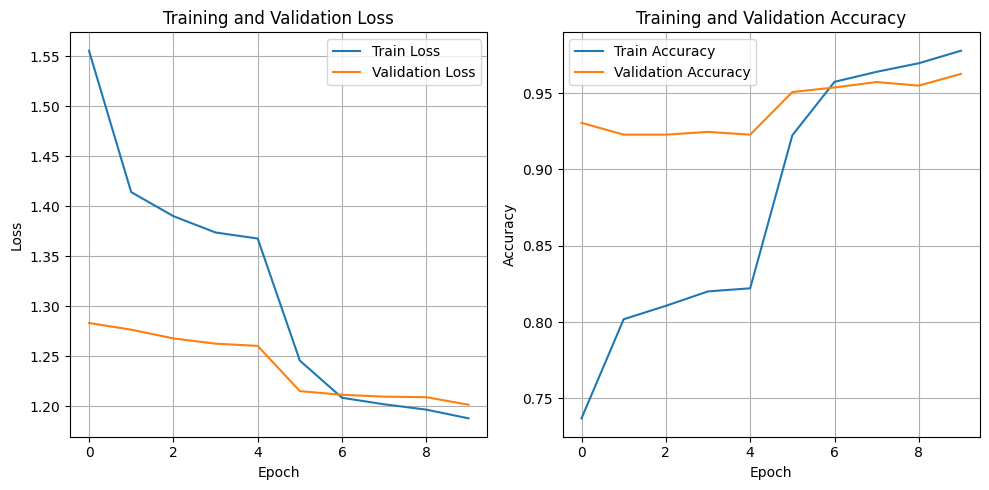

In [ ]:
# Affichage des pertes au cours des épochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

# Affichage des précisions au cours des épochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


**Matrice de confusion**

In [ ]:
# Initalisation des listes des prédictions et des labels réels
y_pred = []
y_true = []

# On place le modèle en mode évaluation.
model_efficientnet.eval()

# Itération sur le test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_efficientnet(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calcul et affichage du score de précision
print(f"Accuracy on test set: {accuracy}")

# Calcul et affichage de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy on test set: 0.9473684210526315
Confusion Matrix:
[[135   0   0   1   6   0   0]
 [  0  52   0   0   0   0   0]
 [  0   0  21   0   0   0   0]
 [  1   2   0  74   1   0   0]
 [  4   4   0   1 103   0   0]
 [  0   0   2   0   0   4   3]
 [  0   0   0   0   0   0  61]]


**Analyse de plusieurs métrique de scores : précision, rappel, et f1**

In [ ]:
# Initialisation des listes de prédictions et des vrais labels.
y_pred_test = []
y_true_test = []
y_pred_val = []
y_true_val = []

# Evaluation sur le test set
model_efficientnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_efficientnet(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())

# Evaluation sur le test de validation
model_efficientnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_efficientnet(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_val.extend(predicted.cpu().numpy())
        y_true_val.extend(labels.cpu().numpy())


# Calcul de la précison, du rappel et du score f1 du test set
precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
f1_test = f1_score(y_true_test, y_pred_test, average='weighted')

# Affichage
print(f"Test Set Metrics:")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-score: {f1_test}")

# Calcul de la précison, du rappel et du score f1 du validation set
precision_val = precision_score(y_true_val, y_pred_val, average='weighted')
recall_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

# Affichage
print(f"\nValidation Set Metrics:")
print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1-score: {f1_val}")


Test Set Metrics:
Precision: 0.9740442283977755
Recall: 0.9734982332155477
F1-score: 0.9736484733446458

Validation Set Metrics:
Precision: 0.9643531973446934
Recall: 0.9640071985602879
F1-score: 0.9640099946327949


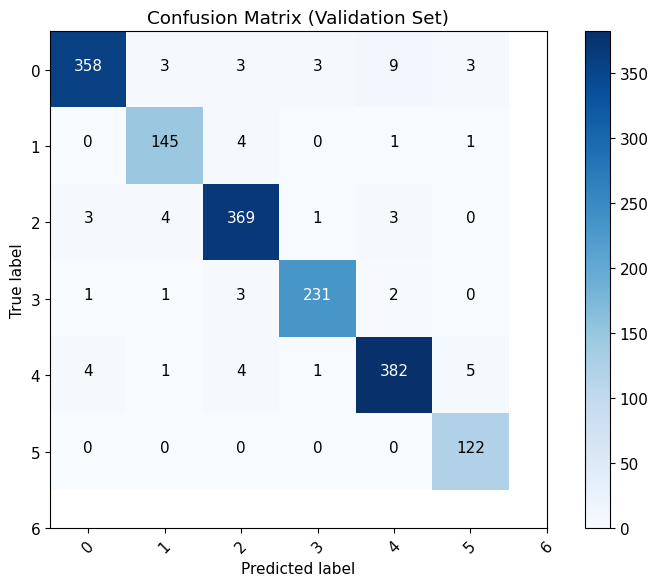

In [ ]:
# On calcul à nouveau la matrice de confusion
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Affichage
plt.figure(figsize=(8, 6))
plt.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Validation Set)')
plt.colorbar()

classes = list(range(7)) # Replace with your actual class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm_val.max() / 2.
for i, j in itertools.product(range(cm_val.shape[0]), range(cm_val.shape[1])):
    plt.text(j, i, format(cm_val[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm_val[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [ ]:
# Calcul des métriques de performances classe par classe
precision_per_class = precision_score(y_true_val, y_pred_val, average=None)
recall_per_class = recall_score(y_true_val, y_pred_val, average=None)
f1_per_class = f1_score(y_true_val, y_pred_val, average=None)

# Affichage
for i, precision in enumerate(precision_per_class):
    print(f"Precision for {classes[i]}: {precision}")
    print(f"Recall for {classes[i]}: {recall_per_class[i]}")
    print(f"F1-score for {classes[i]}: {f1_per_class[i]}\n")

Precision for 0: 0.9781420765027322
Recall for 0: 0.9445910290237467
F1-score for 0: 0.9610738255033557

Precision for 1: 0.9415584415584416
Recall for 1: 0.9602649006622517
F1-score for 1: 0.9508196721311475

Precision for 2: 0.9634464751958225
Recall for 2: 0.9710526315789474
F1-score for 2: 0.9672346002621232

Precision for 3: 0.9788135593220338
Recall for 3: 0.9705882352941176
F1-score for 3: 0.9746835443037974

Precision for 4: 0.9622166246851386
Recall for 4: 0.9622166246851386
F1-score for 4: 0.9622166246851386

Precision for 5: 0.9312977099236641
Recall for 5: 1.0
F1-score for 5: 0.9644268774703557



### **III.3 Confiance**

Ici on évalue à quel point notre modèle est confiant dans ses prédictions. Un score de confiance satisfaisant est généralement similaire à un score de précision.

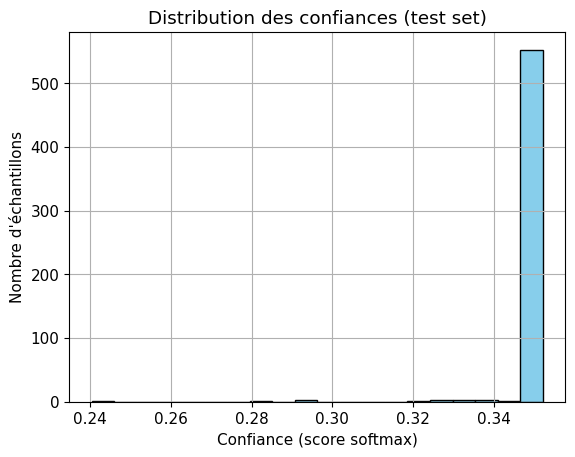

In [ ]:
model_efficientnet.eval()
confidences = []
corrects = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_efficientnet(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        confidences.extend(max_probs.cpu().numpy())
        corrects.extend((preds == labels).cpu().numpy())

confidences = np.array(confidences)
corrects = np.array(corrects)

# ---- Courbe globale
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des confiances (test set)")
plt.xlabel("Confiance (score softmax)")
plt.ylabel("Nombre d'échantillons")
plt.grid(True)
plt.show()


**Remarque :** On peut voir que le score de confiance est en moyenne autour de 0.34 - 0.35, ce qui est très faible par rapport à la précision de notre modèle, avoisinant les 96%. Cela signifie que bien que le modèle soit peu confiant, il a très souvent raison.

Si nous étions dans un cas où beaucoup de classes seraient présentes (plus de 20 classes différentes par exemple), un score de confiance de cet ordre de grandeur aurait pu être considéré comme normal. Cependant ici nous n'évoluons qu'avec 6 classes différentes.

Il est compliqué d'en faire beaucoup d'interprétation. On pourrait s'inquiéter du fait que ce score de confiance, bien qu'il n'ait que peu d'impact sur les performances du test ou valid set, en ait bien plus sur des images toutes nouvelles hors de notre environnement. Cela signifie que ces datasets ont été collectées de manière similaire, que ce soit dans le train ou test set. Si l'on cherche à tester notre modèle sur des datasets différents, il y a selon moi des risques que les résultats soient moins satsifaisants.

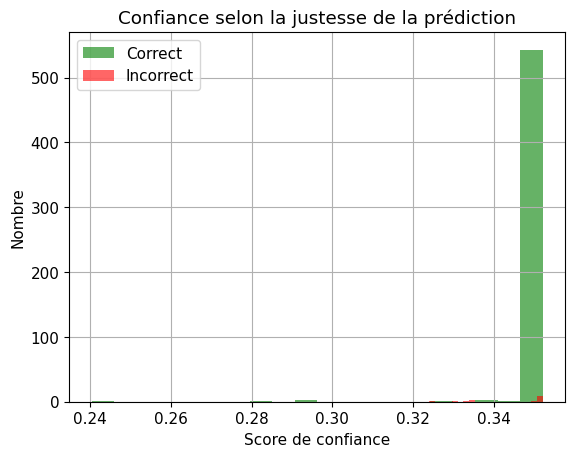

In [ ]:
plt.hist(confidences[corrects == 1], bins=20, alpha=0.6, label='Correct', color='green')
plt.hist(confidences[corrects == 0], bins=20, alpha=0.6, label='Incorrect', color='red')
plt.title("Confiance selon la justesse de la prédiction")
plt.xlabel("Score de confiance")
plt.ylabel("Nombre")
plt.legend()
plt.grid(True)
plt.show()


Ici on calcul et affiche la courbe de calibration. Celle ci affiche l'accuracy d'une prédiction en fonction de son score de confiance. On compare cette courbe à celle qui serait parfaitement calibrée (la confiance prédite moyenne est équivalent à sa précision moyenne correspondante).

Au vu des résultats, on peut remarque que la courve de calibration confirme ceux obtenus auparavant. Le taux de bonnes prédictions est bien plus élevé que la confiance avec laquelle ces prédictions ont été faites.

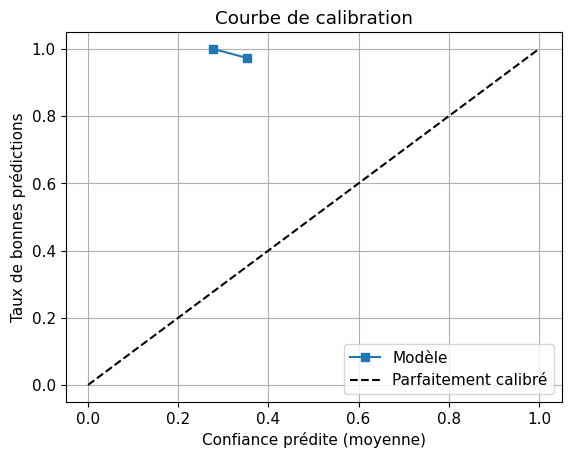

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    corrects, confidences, n_bins=10
)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Modèle")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.xlabel("Confiance prédite (moyenne)")
plt.ylabel("Taux de bonnes prédictions")
plt.title("Courbe de calibration")
plt.legend()
plt.grid(True)
plt.show()


La courbe "Accuracy vs Coverage" affiche l'évolution du score de précision de notre modèle en fonction d'un seuil de confiance en dessous duquel une prédiction ne serait pas retenu.

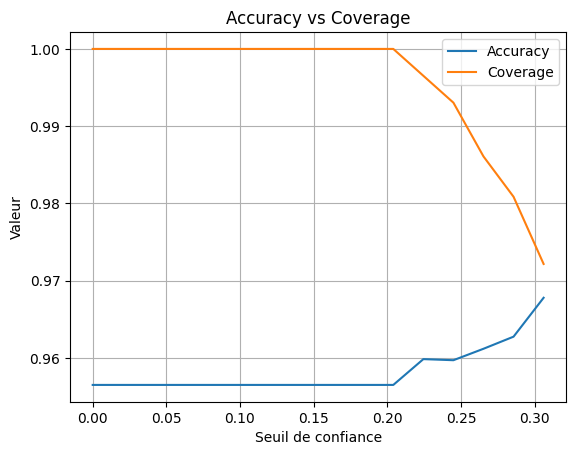

In [ ]:
thresholds = np.linspace(0, 1, 50)
accuracies = []
coverages = []

for t in thresholds:
    mask = confidences >= t
    if mask.sum() == 0:
        continue
    acc = corrects[mask].mean()
    accuracies.append(acc)
    coverages.append(mask.mean())

plt.plot(thresholds[:len(accuracies)], accuracies, label="Accuracy")
plt.plot(thresholds[:len(coverages)], coverages, label="Coverage")
plt.xlabel("Seuil de confiance")
plt.ylabel("Valeur")
plt.title("Accuracy vs Coverage")
plt.legend()
plt.grid(True)
plt.show()


Temperature scaling :

Le temperature scaling permet de manière générale à améliorer le score de confiance d'un modèle. Dans le sens "améliorer" j'entends le rendre plus crédible par rapport à ses performances.

Le but est de diviser les probabilités de confiance de chaque classes par un facteur T. Au fur et à mesure du Temperature Scaling, le modèle va chercher à trouver un T optimal. Si T<1, alors le modèle aura augmenter les scores de confiance. Si T>1, alors il les aura diminuer.

In [ ]:


class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        return logits / self.temperature

    def set_temperature(self, valid_loader):
        self.eval()
        logits_list = []
        labels_list = []

        with torch.no_grad():
            for input, label in valid_loader:
                input = input.to(next(self.model.parameters()).device)
                # input = input.cpu()
                # label = label.cpu()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)

        logits = torch.cat(logits_list)
        labels = torch.cat(labels_list)
        nll_criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(logits / self.temperature, labels)
            loss.backward()
            return loss

        optimizer.step(eval)
        print(f"Optimal temperature: {self.temperature.item()}")
        return self


On peut voir qu'on trouve ici un T = 1.32. Le Temperature Scaling aura donc diminué les score de confiance, ce qui est encore plus troublant.

In [ ]:
# Crée le wrapper autour du modèle déjà entraîné
model_ts = ModelWithTemperature(model_efficientnet)
# model_ts = ModelWithTemperature(model_efficientnet)

# Apprend la température optimale sur le jeu de validation
model_ts.set_temperature(test_loader)


Optimal temperature: 1.3242689371109009


ModelWithTemperature(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [ ]:
model_ts.eval()
with torch.no_grad():
    outputs = model_ts(images)  # déjà temp-scaled
    probs = torch.softmax(outputs, dim=1)


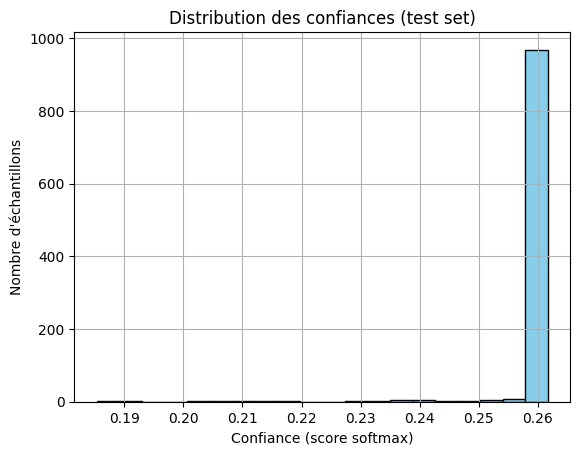

In [ ]:
confidences = []
corrects = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ts(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        confidences.extend(max_probs.cpu().numpy())
        corrects.extend((preds == labels).cpu().numpy())

confidences = np.array(confidences)
corrects = np.array(corrects)

# ---- Courbe globale
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des confiances (test set)")
plt.xlabel("Confiance (score softmax)")
plt.ylabel("Nombre d'échantillons")
plt.grid(True)
plt.show()

In [ ]:
print(f"Température apprise : {model_ts.temperature.item():.4f}")


Température apprise : 1.3243


### **III.4 Top-k Accuracies**

Ici on évalue l'évolution des scores de précision du modèle si on prend le top-2 voir le top-3 des prédictions. On peut voir que les résultats sont très haut, passant de 96% en top-1 accuracy à 99% en top-2 accuracy. Evidemment notre modèle comporte assez peu de classes, donc ces performances sont à relativiser.

In [ ]:
top1_correct = 0
top2_correct = 0
top3_correct = 0
total = 0

model_efficientnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_efficientnet(images)

        # Top-k predictions
        _, top3_preds = torch.topk(outputs, k=3, dim=1)  # top3 predictions
        total += labels.size(0)

        # Top-1
        top1_correct += (top3_preds[:, 0] == labels).sum().item()
        # Top-3
        top2_correct += sum([labels[i] in top3_preds[i, :2] for i in range(labels.size(0))])
        # Top-5
        top3_correct += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

        # # Enregistrement pour d'autres métriques éventuellement
        # y_pred_test.extend(top3_preds[:, 0].cpu().numpy())  # top-1 prediction
        # y_true_test.extend(labels.cpu().numpy())

# Affichage des résultats
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-2 Accuracy: {100 * top2_correct / total:.2f}%")
print(f"Top-3 Accuracy: {100 * top3_correct / total:.2f}%")


Top-1 Accuracy: 96.40%
Top-2 Accuracy: 98.98%
Top-3 Accuracy: 99.40%


### **III.5 ONNX**

Ici on utilise ONNX pour diminuer le temps d'inférence de notre modèle. Cela sera particulièrement utile quand on aura à traiter les nombreuses images obtenues au zoo, apportant un gain de temps conséquent.

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224, device =device)  # batch_size=1, 3 canaux, image 224x224

torch.onnx.export(
    model_efficientnet,                         # modèle PyTorch
    dummy_input,                   # input fictif
    "model.onnx",                  # nom du fichier de sortie
    input_names=["input"],         # nom de l'entrée
    output_names=["output"],       # nom de la sortie
    dynamic_axes={                 # utile si batch size varie
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
    opset_version=11               # version recommandée
)


In [ ]:
session = onnxruntime.InferenceSession("model.onnx")

# exemple d'entrée (même shape que dummy_input)
img = np.random.randn(1, 3, 224, 224).astype(np.float32)
inputs = {session.get_inputs()[0].name: img}

outputs = session.run(None, inputs)
print(outputs[0])

[[   0.075432      0.5535    0.041741     0.19671     0.13178  0.00083178]]


In [ ]:
# Load and preprocess the image
img_path = '/content/loutre-d-europe_1071_5_orig.jpg'  # Replace with your image path
img = Image.open(img_path)

transform_class = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform_class(img).unsqueeze(0).numpy()


# Perform inference
inputs = {session.get_inputs()[0].name: input_tensor}
outputs = session.run(None, inputs)

# Get the predicted class
predicted_class_index = np.argmax(outputs[0])

# Print the prediction
print(f"Predicted class index: {predicted_class_index}")


Predicted class index: 4


### **III.6  Streamlit**

Streamlit permet de faire une simple API locale dans lequel on peut choisir l'image que l'on souhaite, et qu'on renvoit les prédictions faites sur l'image. Une version avec Flask est proposée plus bas, permettant cette fois-ci de séléctionner un dossier entier d'images.

In [ ]:
# --- Configuration de la page ---
st.set_page_config(page_title="Classification Animale", page_icon="🐾", layout="centered")

# --- En-tête ---
st.markdown("<h1 style='text-align: center; color: #4B8BBE;'>Classification d'animaux 🐾</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center;'>Téléverse une image d'animal pour obtenir une prédiction !</p>", unsafe_allow_html=True)

# --- Chargement du modèle ---
model = models.inception_v3(pretrained=True)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)

weights_path = r"C:\Users\HP\Documents\Mulhouse\Poids\inception_weights_version2.pth"
state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

# --- Classes ---
classes = ['blaireau', 'chevreuil', 'renard', 'hérisson', 'loutre', 'mustélidé']

# --- Prétraitement ---
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Uploader ---
uploaded_file = st.file_uploader("📤 Choisis une image (JPG ou PNG)", type=["jpg", "png"])

if uploaded_file is not None:
    col1, col2 = st.columns([1, 2])
    image = Image.open(uploaded_file).convert("RGB")
    with col1:
        st.image(image, caption="Image chargée", use_container_width=True)

    # --- Prédiction ---
    input_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_tensor)
        proba = torch.nn.functional.softmax(outputs[0], dim=0)
        top1 = torch.argmax(proba).item()

    # --- Résultats ---
    with col2:
        st.success(f"### 🧠 Classe prédite : `{classes[top1]}`")
        st.markdown("#### 🔍 Probabilités par classe :")
        for i, p in enumerate(proba):
            st.progress(p.item())
            st.write(f"**{classes[i]}** : {p:.2%}")



2025-04-29 08:39:56.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 08:39:56.865 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 08:39:56.866 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 08:39:56.866 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 08:39:56.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 08:39:56.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 08:39:56.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


**Flask**

In [ ]:
from flask import Flask, request, render_template
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn

app = Flask(__name__)

# Chargement du modèle
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)  # 6 classes

weights_path = r"C:\Users\HP\Documents\Mulhouse\Poids\inception_weights_version2.pth"
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.eval()

# Classes
classes = ['blaireau', 'chevreuil', 'renard', 'hérisson', 'loutre', 'mustélidé']

# Prétraitement
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# @app.route('/', methods=['GET', 'POST'])
# def index():
#     result = None
#     scores = None

#     if request.method == 'POST':
#         file = request.files['image']
#         if file:
#             image = Image.open(file.stream).convert("RGB")
#             input_tensor = transform(image).unsqueeze(0)

#             with torch.no_grad():
#                 outputs = model(input_tensor)
#                 proba = torch.nn.functional.softmax(outputs[0], dim=0)
#                 top1 = torch.argmax(proba).item()

#             result = classes[top1]
#             scores = {classes[i]: float(proba[i]) for i in range(len(classes))}

#     return render_template("index.html", result=result, scores=scores)


# @app.route("/", methods=["GET", "POST"])
# def index():
#     results = []
#     if request.method == "POST":
#         files = request.files.getlist("images")
#         for file in files:
#             image = Image.open(file).convert("RGB")
#             input_tensor = transform(image).unsqueeze(0)
#             with torch.no_grad():
#                 outputs = model(input_tensor)
#                 proba = torch.nn.functional.softmax(outputs[0], dim=0)
#                 top1 = torch.argmax(proba).item()
#             results.append({
#                 "filename": file.filename,
#                 "classe": classes[top1],
#                 "probas": [f"{classes[i]}: {p:.2f}" for i, p in enumerate(proba)]
#             })
#     return render_template("index.html", results=results)

@app.route("/", methods=["GET", "POST"])
def index():
    results = []
    compteur = {classe: 0 for classe in classes}

    if request.method == "POST":
        files = request.files.getlist("images")
        for file in files:
            image = Image.open(file).convert("RGB")
            input_tensor = transform(image).unsqueeze(0)
            with torch.no_grad():
                outputs = model(input_tensor)
                proba = torch.nn.functional.softmax(outputs[0], dim=0)
                top1 = torch.argmax(proba).item()
            classe_predite = classes[top1]
            compteur[classe_predite] += 1

            results.append({
                "filename": file.filename,
                "classe": classe_predite,
                "probas": [f"{classes[i]}: {p:.2f}" for i, p in enumerate(proba)]
            })

    return render_template("index.html", results=results, compteur=compteur)

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
# # Partie HTML

# <!DOCTYPE html>
# <html>
# <head>
#     <title>Classification d'animaux</title>
# </head>
# <body>
#     <h1>Classification d'animaux 🐾</h1>
#     <form method="post" enctype="multipart/form-data">
#         <input type="file" name="images" multiple>
#         <input type="submit" value="Envoyer">
#     </form>

#     <!-- {% if result %}
#         <h2>Classe prédite : {{ result }}</h2>
#         <h3>Scores :</h3>
#         <ul>
#             {% for cls, prob in scores.items() %}
#                 <li>{{ cls }} : {{ "%.2f"|format(prob) }}</li>
#             {% endfor %}
#         </ul>
#     {% endif %} -->

#     {% if results %}
#         <h2>Résultats :</h2>
#         {% for res in results %}
#             <h3>{{ res.filename }} → {{ res.classe }}</h3>
#             <ul>
#                 {% for score in res.probas %}
#                     <li>{{ score }}</li>
#                 {% endfor %}
#             </ul>
#         {% endfor %}

#         <h2>Décompte par animal :</h2>
#         <ul>
#           {% for animal, count in compteur.items() %}
#             <li>{{ animal }} : {{ count }}</li>
#           {% endfor %}
#         </ul>

#     {% endif %}
# </body>
# </html>


### **III.7 Explainibility**



#### **III.7.1 Matrices d'activation**

In [ ]:


# Print all keys in the state_dict of model_efficientnet
print(model_efficientnet.state_dict().keys())


odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.0.block.0.0.weight', 'features.1.0.block.0.1.weight', 'features.1.0.block.0.1.bias', 'features.1.0.block.0.1.running_mean', 'features.1.0.block.0.1.running_var', 'features.1.0.block.0.1.num_batches_tracked', 'features.1.0.block.1.fc1.weight', 'features.1.0.block.1.fc1.bias', 'features.1.0.block.1.fc2.weight', 'features.1.0.block.1.fc2.bias', 'features.1.0.block.2.0.weight', 'features.1.0.block.2.1.weight', 'features.1.0.block.2.1.bias', 'features.1.0.block.2.1.running_mean', 'features.1.0.block.2.1.running_var', 'features.1.0.block.2.1.num_batches_tracked', 'features.1.1.block.0.0.weight', 'features.1.1.block.0.1.weight', 'features.1.1.block.0.1.bias', 'features.1.1.block.0.1.running_mean', 'features.1.1.block.0.1.running_var', 'features.1.1.block.0.1.num_batches_tracked', 'features.1.1.block.1.fc1.weight

In [ ]:
img_path = 'Herisson-Fotolia.jpg'
img = Image.open(img_path).convert('RGB')
img_tensor = transform_classification(img).unsqueeze(0).to(device)

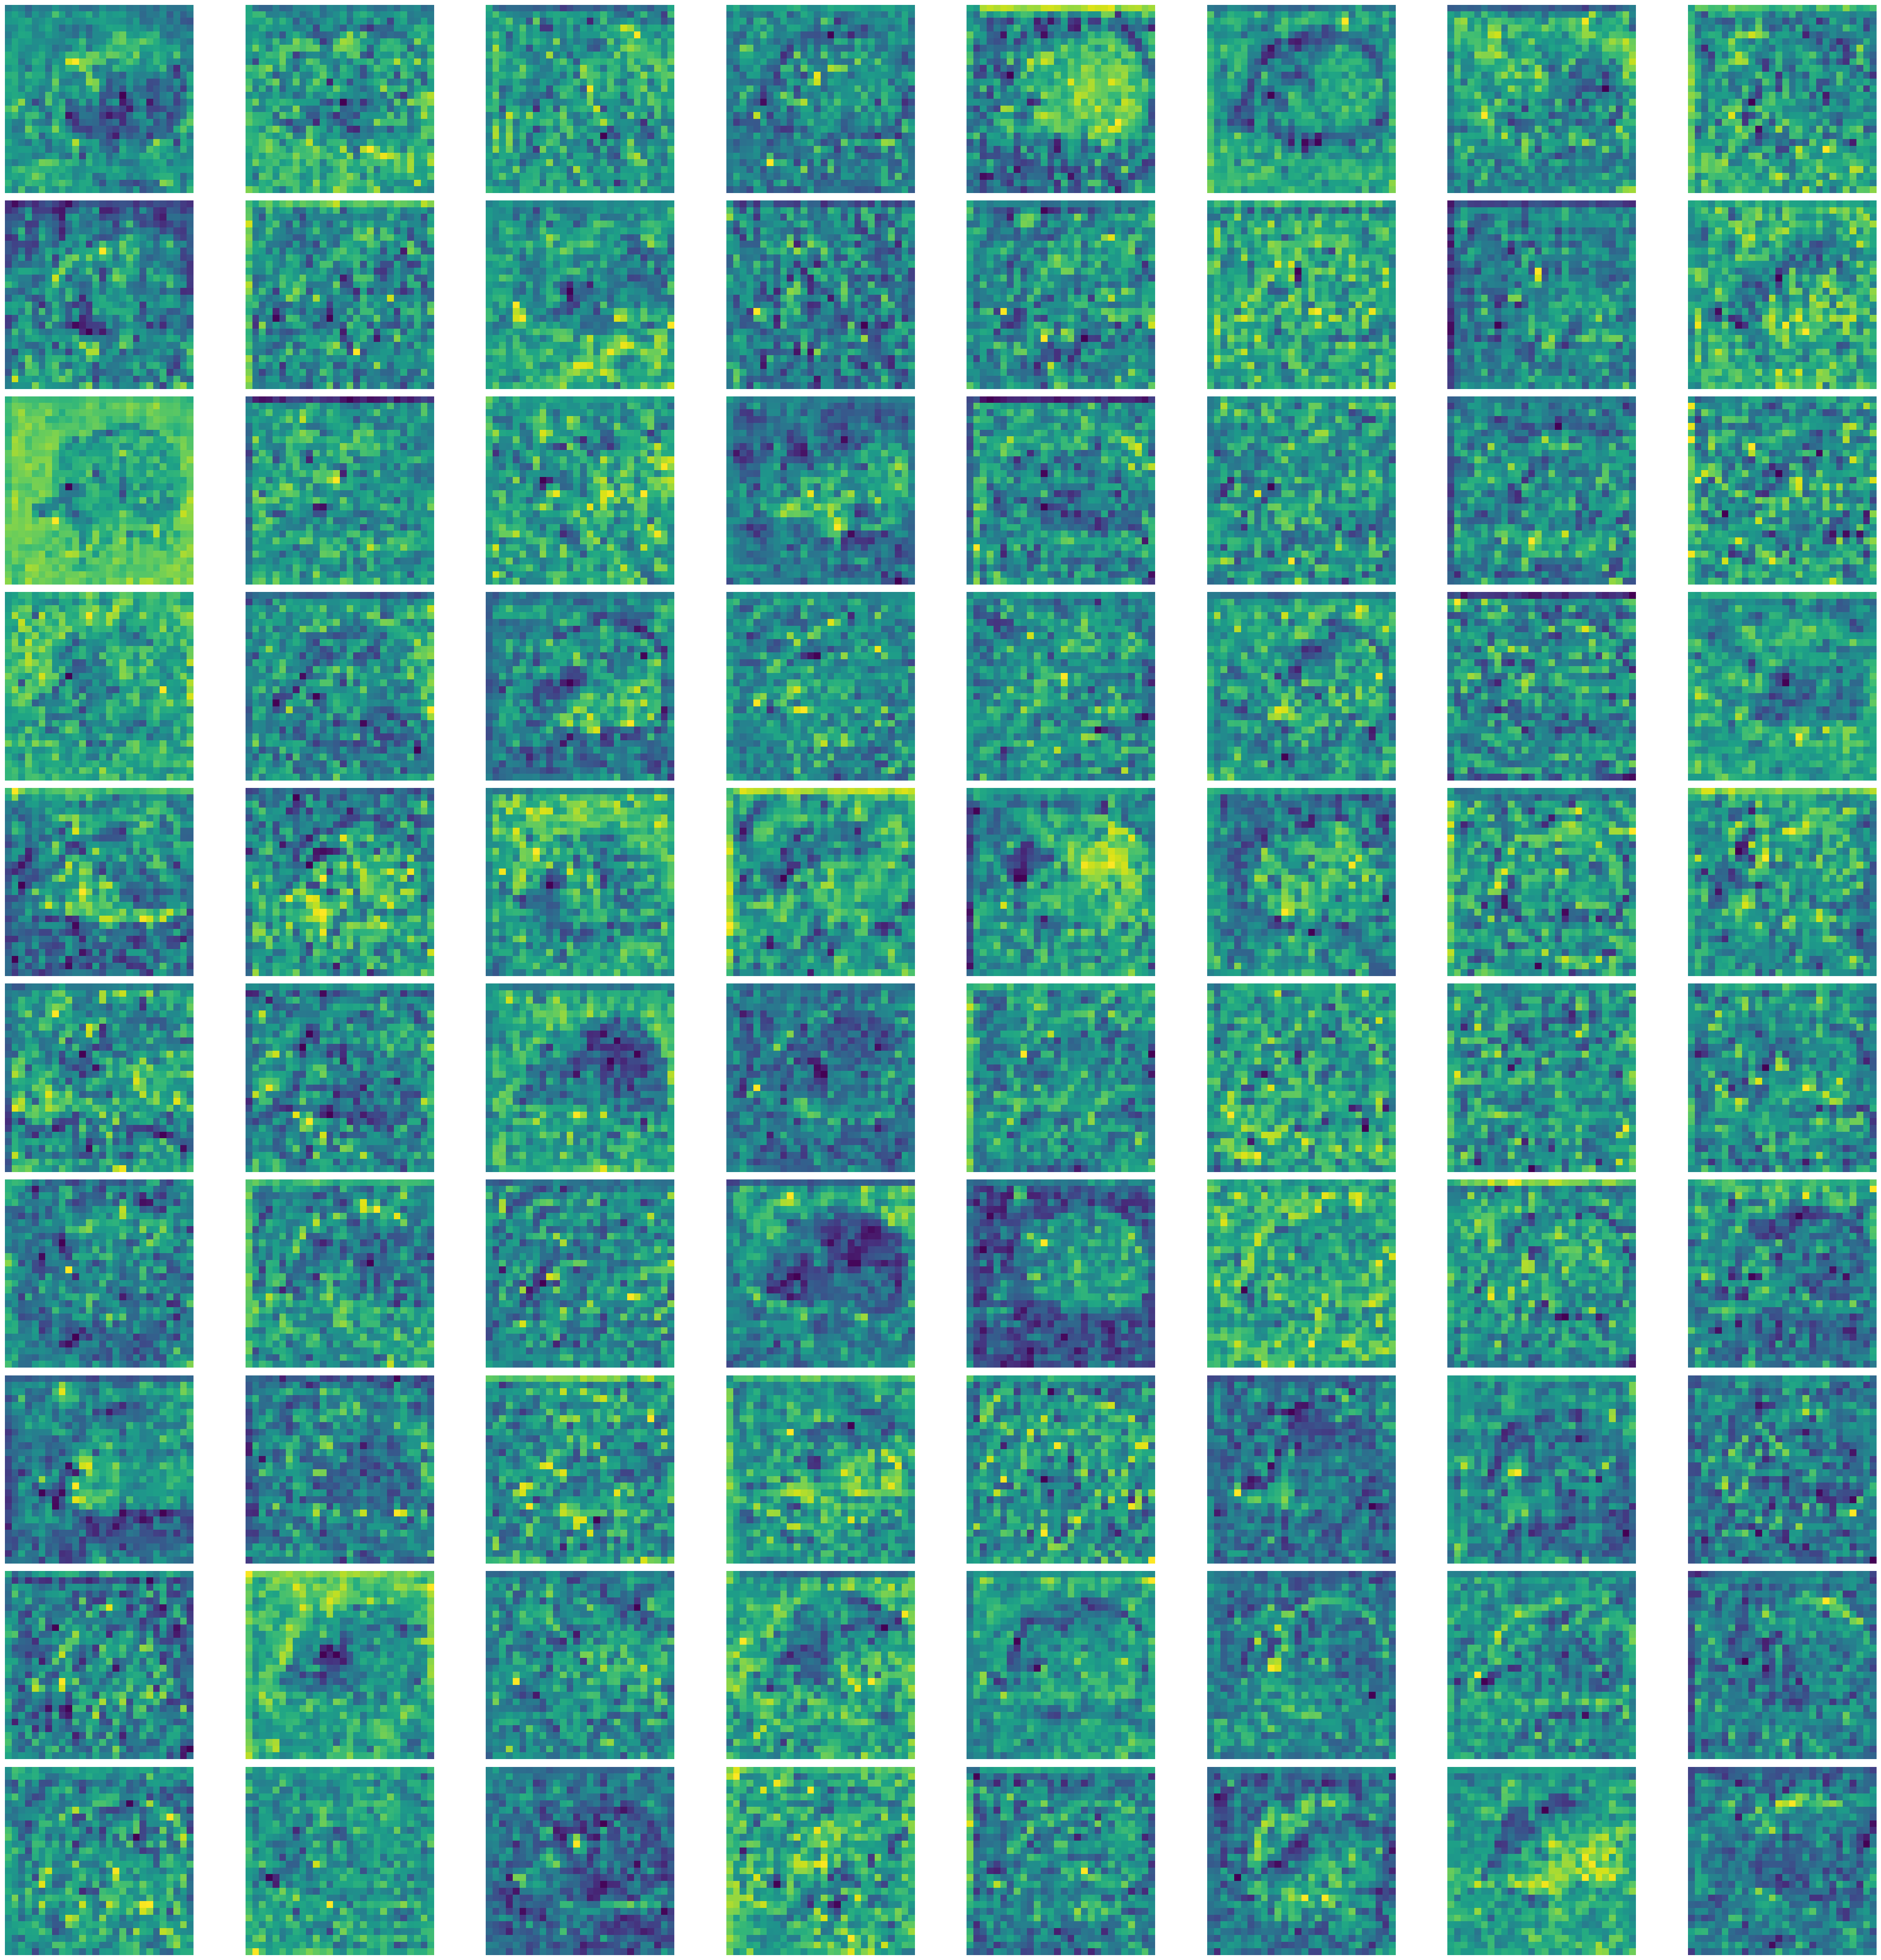

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Exemple : choisir une couche (tu peux en ajouter d'autres)
model_efficientnet.features[3][1].register_forward_hook(get_activation('block4'))

# === 4. Propagation avant ===
with torch.no_grad():
    _ = model_efficientnet(img_tensor)

# === 5. Visualisation ===
activation = activations['block4'][0]  # shape: [C, H, W]
num_channels = activation.shape[0]
cols = 8
rows = num_channels // cols

plt.figure(figsize=(40, 40))
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(activation[i].cpu().numpy(), cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
rows

4

#### **III.7.2 Occlusion Sensitivity**

Prediction avec occlusion : renard


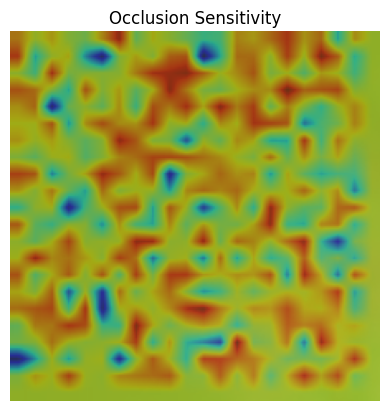

In [ ]:
img = Image.open("R.jpg").convert("RGB")
input_tensor = transform_classification(img).unsqueeze(0).to(device)

# === 2. Prédiction initiale ===
with torch.no_grad():
    output = model_efficientnet(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_score = torch.nn.functional.softmax(output, dim=1)[0, pred_class].item()

# === 3. Paramètres d’occlusion ===
window_size = 20
stride = 10
height, width = 224, 224
heatmap = np.zeros((height // stride, width // stride))

# === 4. Appliquer occlusion ===
for i in range(0, height - window_size, stride):
    for j in range(0, width - window_size, stride):
        img_occluded = input_tensor.clone()
        img_occluded[:, :, i:i+window_size, j:j+window_size] = 0.5  # gris

        with torch.no_grad():
            out_occ = model_efficientnet(img_occluded)
            pred_occ = torch.argmax(out_occ,dim=1).item()
            score_occ = torch.nn.functional.softmax(out_occ, dim=1)[0, pred_class].item()

        diff = pred_score - score_occ
        heatmap[i // stride, j // stride] = diff

# === 5. Affichage ===
print("Prediction avec occlusion :", classes[pred_occ])
heatmap_resized = cv2.resize(heatmap, (224, 224))
plt.imshow(np.array(img))
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.title("Occlusion Sensitivity")
plt.axis('off')
plt.show()

## **IV. ResNet**

In [ ]:
resnet50_model = models.resnet50(pretrained=True)

# Modifier la dernière couche entièrement connectée pour correspondre au nombre de classes
num_classes = 7 # Remplacez par le nombre de vos classes
resnet50_model.fc = nn.Sequential( # Change classifier[1] to fc
    nn.Linear(resnet50_model.fc.in_features, num_classes), # Access in_features from resnet50_model.fc
    nn.Softmax(dim=1)  # Ajout de Softmax
)

# Envoyer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model = resnet50_model.to(device)

resnet50_model


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

state_dict = torch.load('/content/resnet50_weights.pth', map_location=device)

# Load the state dictionary into the model
resnet50_model.load_state_dict(state_dict)



<All keys matched successfully>

### **IV.1 Entraînement**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
# scheduler = CosineAnnealingLR(optimizer, T_max=50)

NameError: name 'resnet50_model' is not defined

In [ ]:

# Freeze all layers except the last one (with softmax) in resnet50_model
for name, param in resnet50_model.named_parameters():
    if "fc.0" not in name:  # Freeze everything except fc.1
        param.requires_grad = True


In [ ]:
# Initialisation du scaler pour le mixed precision
scaler = GradScaler()

num_epochs = 5
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

for epoch in range(num_epochs):
    resnet50_model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Utilisation du autocast pour le mixed precision
        with autocast(device_type='cuda'):  # Contexte pour la précision mixte
            outputs = resnet50_model(images)
            loss = criterion(outputs, labels)

        # Scaler pour éviter les erreurs de précision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  # Mise à jour de l'échelle du scaler

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    scheduler.step(train_accuracy)

    # Évaluation sur le jeu de validation
    resnet50_model.eval()  # Mode évaluation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):  # Utilisation de l'autocast pendant l'évaluation aussi
                outputs = resnet50_model(images)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}", f"Learning Rate: {optimizer.param_groups[0]['lr']:.10f}")


Epoch [1/5], Train Loss: 1.2850, Train Acc: 0.8794, Val Loss: 1.2193, Val Acc: 0.9436 Learning Rate: 0.0000400000
Epoch [2/5], Train Loss: 1.2771, Train Acc: 0.8882, Val Loss: 1.2172, Val Acc: 0.9483 Learning Rate: 0.0000400000
Epoch [3/5], Train Loss: 1.2764, Train Acc: 0.8882, Val Loss: 1.2193, Val Acc: 0.9459 Learning Rate: 0.0000080000
Epoch [4/5], Train Loss: 1.2733, Train Acc: 0.8920, Val Loss: 1.2171, Val Acc: 0.9459 Learning Rate: 0.0000080000
Epoch [5/5], Train Loss: 1.2679, Train Acc: 0.8965, Val Loss: 1.2143, Val Acc: 0.9501 Learning Rate: 0.0000080000


In [ ]:
torch.save(resnet50_model.state_dict(), '/content/resnet50_weights.pth')

### **IV.2 Analyse des résultats**

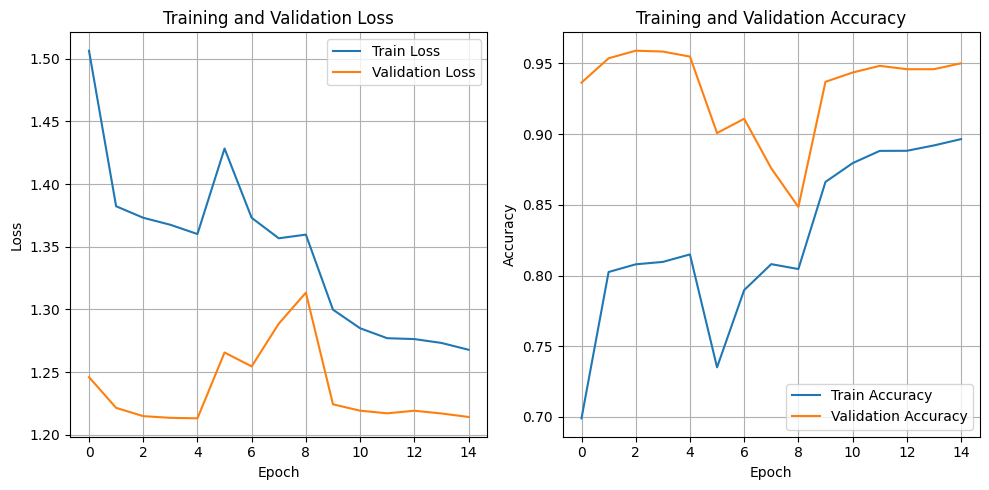

In [ ]:
# Create the first plot for loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

# Create the second plot for accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Initialize lists to store predictions and true labels for test and validation sets
y_pred_test = []
y_true_test = []
y_pred_val = []
y_true_val = []

# Evaluate on the test set
resnet50_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50_model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())

# Evaluate on the validation set
resnet50_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50_model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_val.extend(predicted.cpu().numpy())
        y_true_val.extend(labels.cpu().numpy())


# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
f1_test = f1_score(y_true_test, y_pred_test, average='weighted')

print(f"Test Set Metrics:")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-score: {f1_test}")

# Calculate precision, recall, and F1-score for the validation set
precision_val = precision_score(y_true_val, y_pred_val, average='weighted')
recall_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

print(f"\nValidation Set Metrics:")
print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1-score: {f1_val}")


Test Set Metrics:
Precision: 0.9305129318504649
Recall: 0.9443478260869566
F1-score: 0.9369299282458093

Validation Set Metrics:
Precision: 0.9420578385959736
Recall: 0.9500891265597148
F1-score: 0.945686580306744


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AttributeError: 'list' object has no attribute 'values'

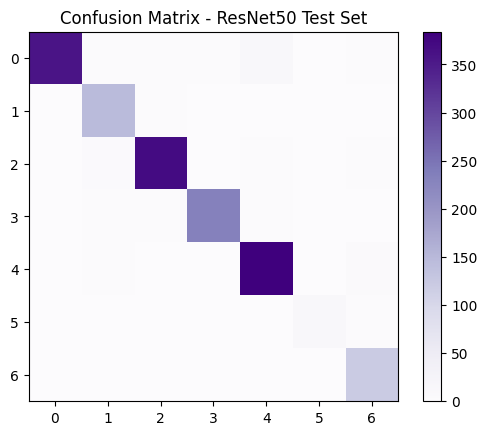

In [ ]:

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true_val, y_pred_val)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion Matrix - ResNet50 Test Set')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes.values(), rotation=45)
plt.yticks(tick_marks, classes.values())

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
torch.save(resnet50_model.state_dict(), '/content/resnet50_weights.pth')


### **IV.3 Confiance**

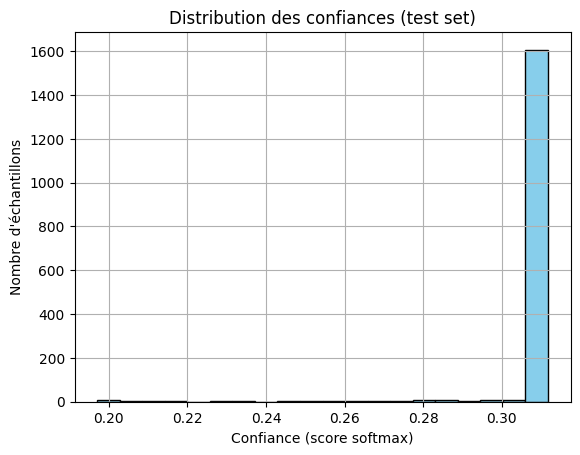

In [ ]:
resnet50_model.eval()
confidences = []
corrects = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50_model(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        confidences.extend(max_probs.cpu().numpy())
        corrects.extend((preds == labels).cpu().numpy())

confidences = np.array(confidences)
corrects = np.array(corrects)

# ---- Courbe globale
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des confiances (test set)")
plt.xlabel("Confiance (score softmax)")
plt.ylabel("Nombre d'échantillons")
plt.grid(True)
plt.show()


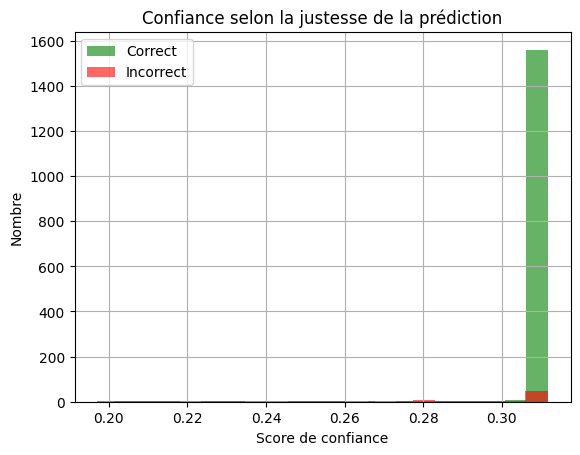

In [ ]:
plt.hist(confidences[corrects == 1], bins=20, alpha=0.6, label='Correct', color='green')
plt.hist(confidences[corrects == 0], bins=20, alpha=0.6, label='Incorrect', color='red')
plt.title("Confiance selon la justesse de la prédiction")
plt.xlabel("Score de confiance")
plt.ylabel("Nombre")
plt.legend()
plt.grid(True)
plt.show()


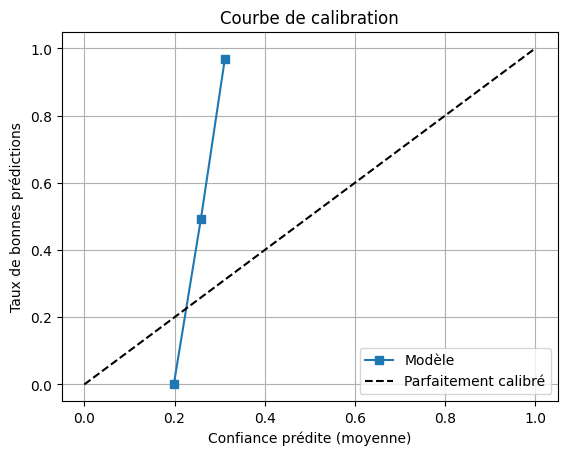

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    corrects, confidences, n_bins=10
)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Modèle")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.xlabel("Confiance prédite (moyenne)")
plt.ylabel("Taux de bonnes prédictions")
plt.title("Courbe de calibration")
plt.legend()
plt.grid(True)
plt.show()


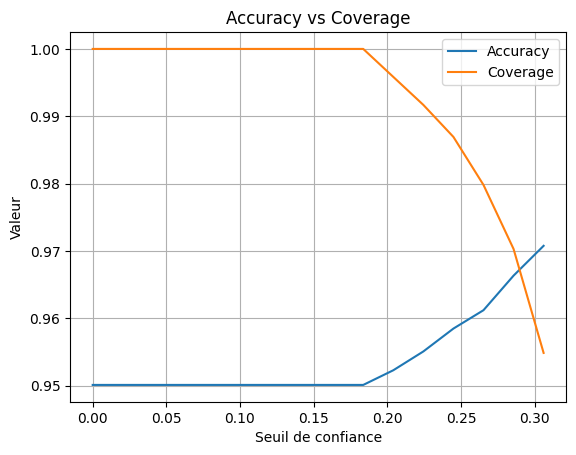

In [ ]:
thresholds = np.linspace(0, 1, 50)
accuracies = []
coverages = []

for t in thresholds:
    mask = confidences >= t
    if mask.sum() == 0:
        continue
    acc = corrects[mask].mean()
    accuracies.append(acc)
    coverages.append(mask.mean())

plt.plot(thresholds[:len(accuracies)], accuracies, label="Accuracy")
plt.plot(thresholds[:len(coverages)], coverages, label="Coverage")
plt.xlabel("Seuil de confiance")
plt.ylabel("Valeur")
plt.title("Accuracy vs Coverage")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Crée le wrapper autour du modèle déjà entraîné
model_ts = ModelWithTemperature(resnet50_model)
# model_ts = ModelWithTemperature(model_efficientnet)

# Apprend la température optimale sur le jeu de validation
model_ts.set_temperature(test_loader)


Optimal temperature: 1.3274232149124146


ModelWithTemperature(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
print(f"Température apprise : {model_ts.temperature.item():.4f}")

Température apprise : 1.3274


### **IV.4 Top-k Accuracies**

In [ ]:
top1_correct = 0
top2_correct = 0
top3_correct = 0
total = 0

resnet50_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50_model(images)

        # Top-k predictions
        _, top3_preds = torch.topk(outputs, k=3, dim=1)  # top3 predictions
        total += labels.size(0)

        # Top-1
        top1_correct += (top3_preds[:, 0] == labels).sum().item()
        # Top-3
        top2_correct += sum([labels[i] in top3_preds[i, :2] for i in range(labels.size(0))])
        # Top-5
        top3_correct += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

        # # Enregistrement pour d'autres métriques éventuellement
        # y_pred_test.extend(top3_preds[:, 0].cpu().numpy())  # top-1 prediction
        # y_true_test.extend(labels.cpu().numpy())

# Affichage des résultats
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-2 Accuracy: {100 * top2_correct / total:.2f}%")
print(f"Top-3 Accuracy: {100 * top3_correct / total:.2f}%")


Top-1 Accuracy: 95.01%
Top-2 Accuracy: 97.50%
Top-3 Accuracy: 98.04%


### **IV.5 Explainibility**

In [ ]:
resnet50_model.layer1[1]

Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [ ]:
img_path = 'R.jpg'
img = Image.open(img_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0)

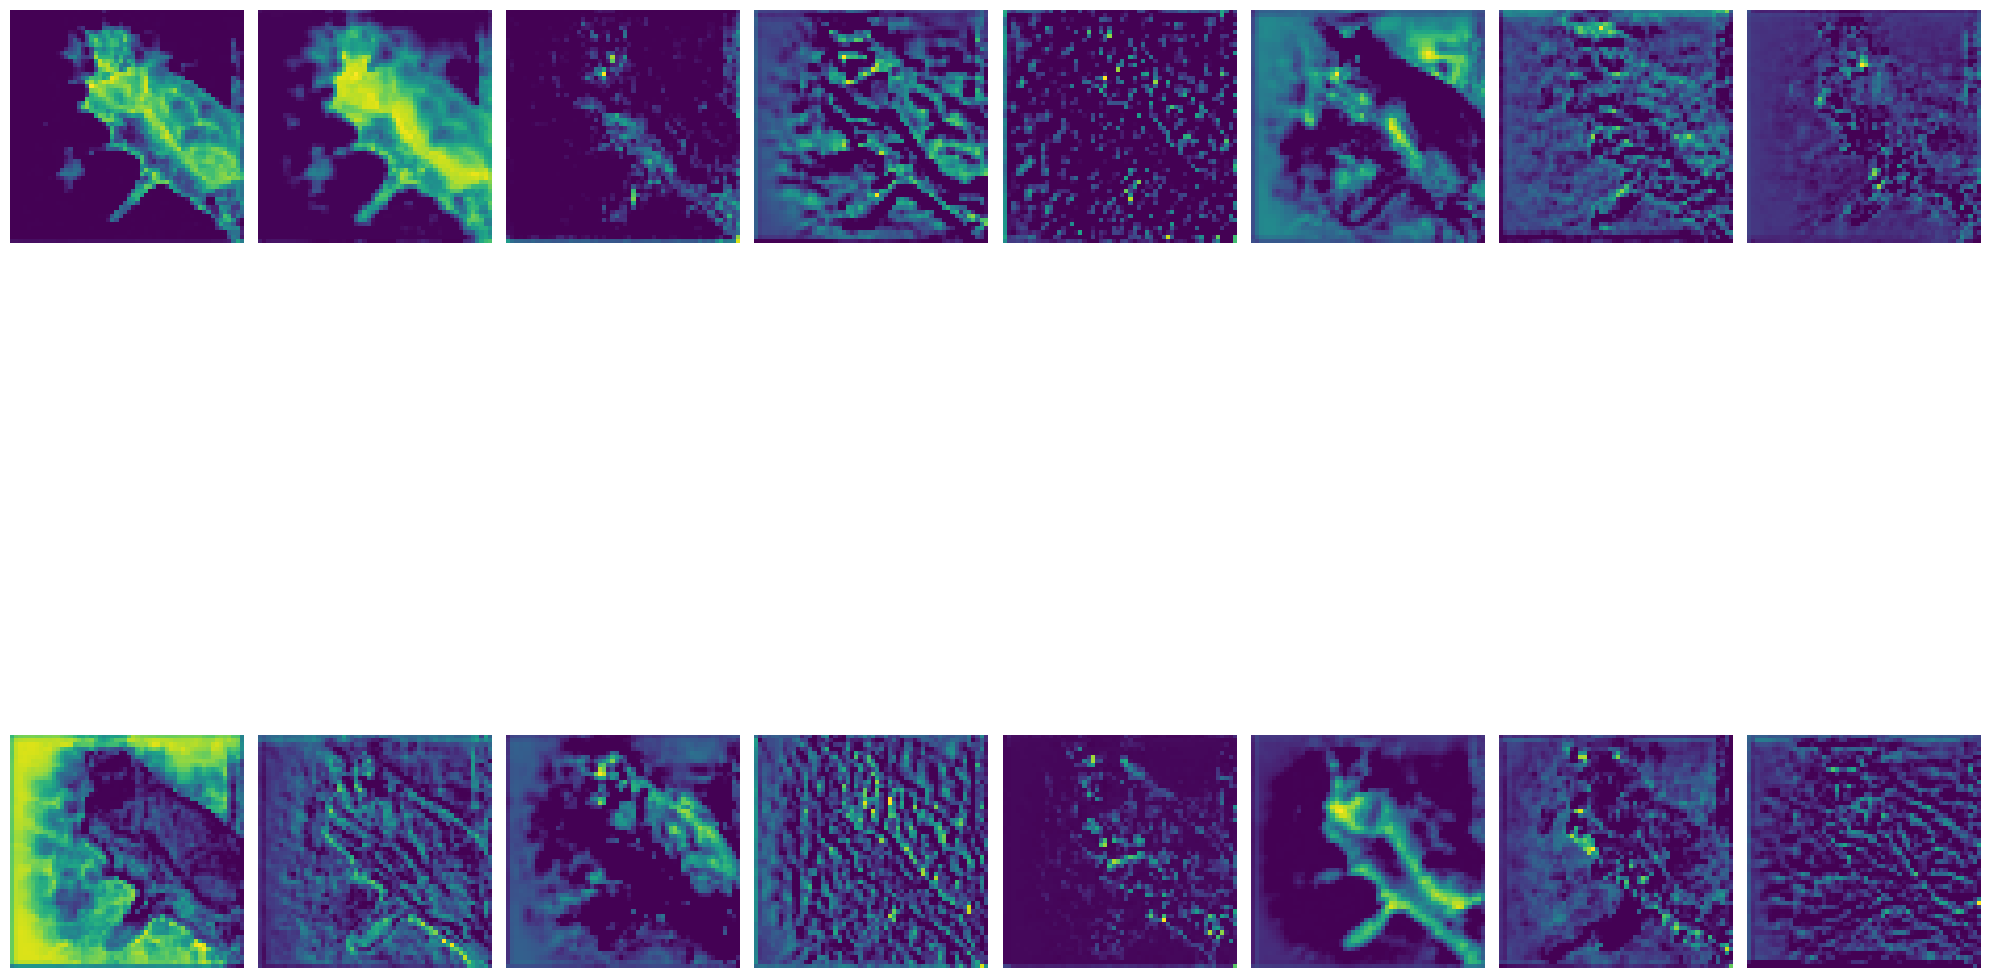

In [ ]:


# === 3. Hook pour capturer les activations ===
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Exemple : choisir une couche (par exemple, "layer1[0]")
resnet50_model.layer1[1].register_forward_hook(get_activation('layer1_block1'))

# === 4. Propagation avant ===
with torch.no_grad():
    _ = resnet50_model(img_tensor)

# === 5. Visualisation ===
activation = activations['layer1_block1'][0]  # shape: [C, H, W]
num_channels = min(20, activation.shape[0])  # Limiter à 30 canaux au maximum
cols = 8
rows = num_channels // cols

plt.figure(figsize=(20, 20))
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(activation[i].cpu().numpy(), cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.show()


## **V. Inception**

### **V.1 Entraînement**

In [ ]:
device

device(type='cuda')

In [ ]:
inception_model = models.inception_v3(pretrained=True)

# Modifier la dernière couche entièrement connectée pour correspondre au nombre de classes
num_classes = 6
inception_model.fc = nn.Linear(inception_model.fc.in_features, num_classes)

# Envoyer le modèle sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_model.to(device)

print(inception_model)

# Définir la fonction de perte, l'optimiseur et le planificateur de taux d'apprentissage
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 243MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
state_dict = torch.load('/content/inception_weights_version2.pth', map_location=device)

# Load the state dictionary into the model
inception_model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [ ]:


# # Access the fully connected layer
# fc_layer = inception_model.fc

# # Get the input features dimension
# in_features = fc_layer.in_features

# # Create a new fully connected layer with 6 output neurons
# new_fc_layer = nn.Linear(in_features, 6)

# # Replace the old fully connected layer with the new one
# inception_model.fc = new_fc_layer

# inception_model.fc.to(device)


In [ ]:
for name, param in inception_model.named_parameters():
    if "fc" not in name:
        param.requires_grad = True

In [ ]:
# Initialisation du scaler pour le mixed precision
scaler = GradScaler()

num_epochs = 3
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

for epoch in range(num_epochs):
    inception_model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Utilisation du autocast pour le mixed precision
        with autocast(device_type='cuda'):  # Contexte pour la précision mixte
            outputs = inception_model(images)
            loss = criterion(outputs.logits, labels)

        # Scaler pour éviter les erreurs de précision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  # Mise à jour de l'échelle du scaler

        running_loss += loss.item()
        correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    scheduler.step(train_accuracy)

    # Évaluation sur le jeu de validation
    inception_model.eval()  # Mode évaluation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type='cuda'):  # Utilisation de l'autocast pendant l'évaluation aussi
                outputs = inception_model(images)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}", f"Learning Rate: {optimizer.param_groups[0]['lr']:.10f}")


Epoch [1/3], Train Loss: 0.0184, Train Acc: 0.9941, Val Loss: 0.1346, Val Acc: 0.9682 Learning Rate: 0.0000400000
Epoch [2/3], Train Loss: 0.0167, Train Acc: 0.9965, Val Loss: 0.1408, Val Acc: 0.9664 Learning Rate: 0.0000400000
Epoch [3/3], Train Loss: 0.0144, Train Acc: 0.9967, Val Loss: 0.1474, Val Acc: 0.9694 Learning Rate: 0.0000080000


In [ ]:
torch.save(inception_model.state_dict(), '/content/inception_weights.pth')


In [ ]:

from google.colab import files
files.download('/content/inception_weights.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **V.2 Analyse des résultats**

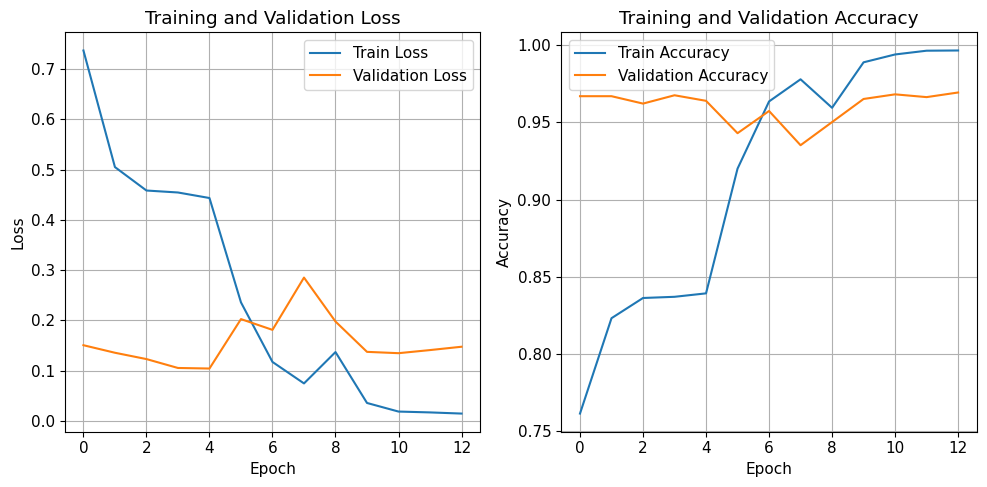

In [ ]:
# Create the first plot for loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()

# Create the second plot for accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
torch.save(inception_model.state_dict(), '/content/inception_weights.pth')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Initialize lists to store predictions and true labels for test and validation sets
y_pred_test = []
y_true_test = []
y_pred_val = []
y_true_val = []

# Evaluate on the test set
inception_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_test.extend(predicted.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())

# Evaluate on the validation set
inception_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_val.extend(predicted.cpu().numpy())
        y_true_val.extend(labels.cpu().numpy())


# Calculate precision, recall, and F1-score for the test set
precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
f1_test = f1_score(y_true_test, y_pred_test, average='weighted')

print(f"Test Set Metrics:")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-score: {f1_test}")

# Calculate precision, recall, and F1-score for the validation set
precision_val = precision_score(y_true_val, y_pred_val, average='weighted')
recall_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

print(f"\nValidation Set Metrics:")
print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1-score: {f1_val}")


Test Set Metrics:
Precision: 0.9773378348334961
Recall: 0.9770318021201413
F1-score: 0.9770154700515414

Validation Set Metrics:
Precision: 0.9698460065440665
Recall: 0.9694061187762447
F1-score: 0.9693981517955673


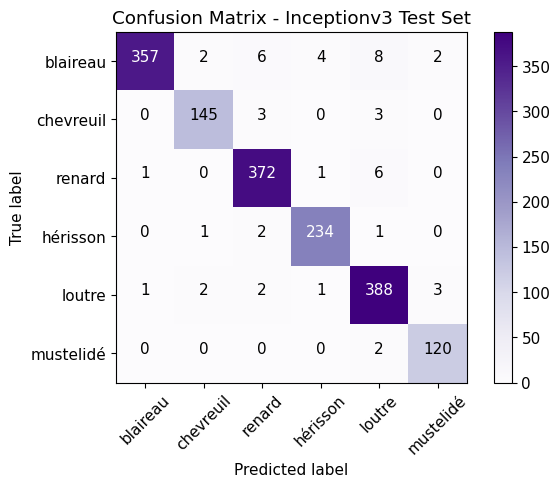

In [ ]:

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true_val, y_pred_val)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Inceptionv3 Test Set')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes.values(), rotation=45)
plt.yticks(tick_marks, classes.values())

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# prompt: afficher la précision par animal

from sklearn.metrics import precision_score

# Assuming y_true_test and y_pred_test are already defined as in your code

# Calculate precision for each class
precision_per_class = precision_score(y_true_val, y_pred_val, average=None)
recall_per_class = recall_score(y_true_val, y_pred_val, average=None)
f1_per_class = f1_score(y_true_val, y_pred_val, average=None)

# Print the precision for each animal
for i, precision in enumerate(precision_per_class):
    print(f"Precision for {classes[i]}: {precision}")
    print(f"Recall for {classes[i]}: {recall_per_class[i]}")
    print(f"F1-score for {classes[i]}: {f1_per_class[i]}\n")


Precision for blaireau: 0.9733333333333334
Recall for blaireau: 0.9630606860158312
F1-score for blaireau: 0.9681697612732095

Precision for chevreuil: 0.9671052631578947
Recall for chevreuil: 0.9735099337748344
F1-score for chevreuil: 0.9702970297029703

Precision for renard: 0.9734748010610079
Recall for renard: 0.9657894736842105
F1-score for renard: 0.9696169088507266

Precision for hérisson: 0.9789915966386554
Recall for hérisson: 0.9789915966386554
F1-score for hérisson: 0.9789915966386554

Precision for loutre: 0.9592875318066157
Recall for loutre: 0.9496221662468514
F1-score for loutre: 0.9544303797468354

Precision for mustelidé: 0.9090909090909091
Recall for mustelidé: 0.9836065573770492
F1-score for mustelidé: 0.9448818897637795



### **V.3 Confiance**

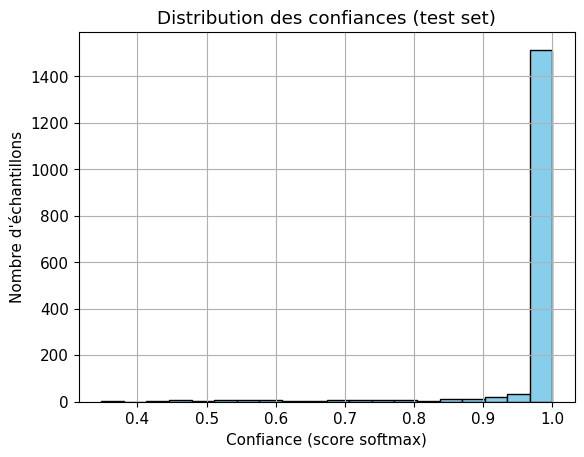

In [ ]:
inception_model.eval()
confidences = []
corrects = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = inception_model(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        confidences.extend(max_probs.cpu().numpy())
        corrects.extend((preds == labels).cpu().numpy())

confidences = np.array(confidences)
corrects = np.array(corrects)

# ---- Courbe globale
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des confiances (test set)")
plt.xlabel("Confiance (score softmax)")
plt.ylabel("Nombre d'échantillons")
plt.grid(True)
plt.show()


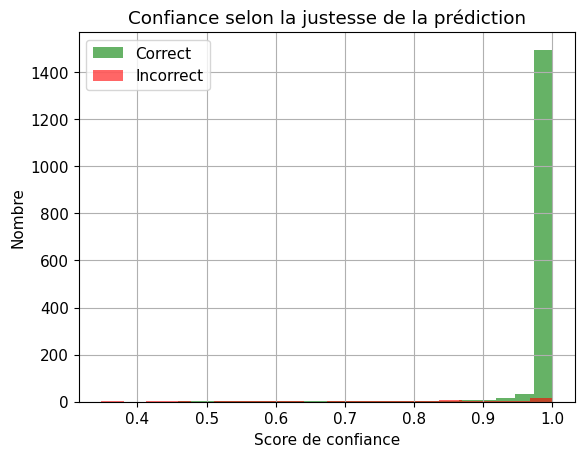

In [ ]:
plt.hist(confidences[corrects == 1], bins=20, alpha=0.6, label='Correct', color='green')
plt.hist(confidences[corrects == 0], bins=20, alpha=0.6, label='Incorrect', color='red')
plt.title("Confiance selon la justesse de la prédiction")
plt.xlabel("Score de confiance")
plt.ylabel("Nombre")
plt.legend()
plt.grid(True)
plt.show()


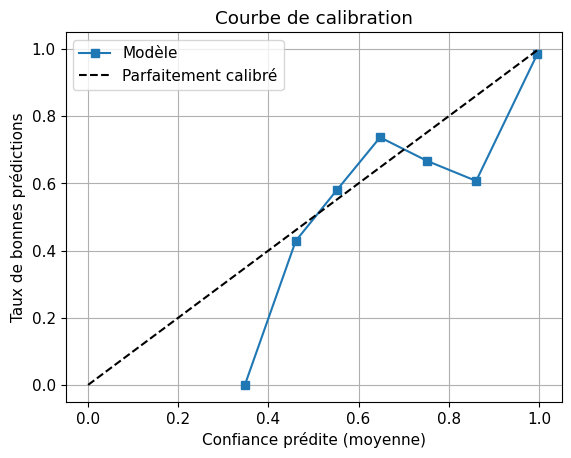

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    corrects, confidences, n_bins=10
)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Modèle")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.xlabel("Confiance prédite (moyenne)")
plt.ylabel("Taux de bonnes prédictions")
plt.title("Courbe de calibration")
plt.legend()
plt.grid(True)
plt.show()


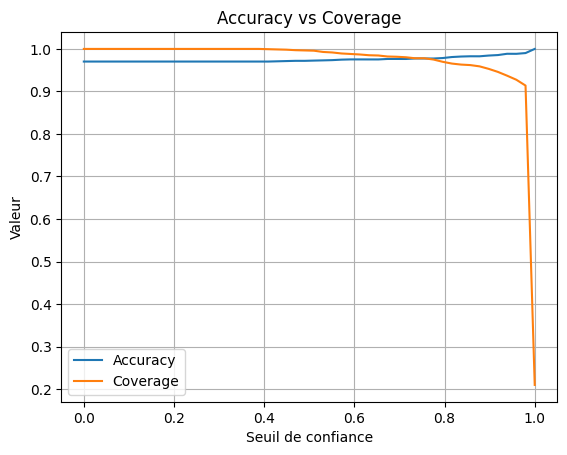

In [ ]:
thresholds = np.linspace(0, 1, 50)
accuracies = []
coverages = []

for t in thresholds:
    mask = confidences >= t
    if mask.sum() == 0:
        continue
    acc = corrects[mask].mean()
    accuracies.append(acc)
    coverages.append(mask.mean())

plt.plot(thresholds[:len(accuracies)], accuracies, label="Accuracy")
plt.plot(thresholds[:len(coverages)], coverages, label="Coverage")
plt.xlabel("Seuil de confiance")
plt.ylabel("Valeur")
plt.title("Accuracy vs Coverage")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Crée le wrapper autour du modèle déjà entraîné
model_ts = ModelWithTemperature(inception_model)
# model_ts = ModelWithTemperature(model_efficientnet)


# Apprend la température optimale sur le jeu de validation
model_ts.set_temperature(val_loader)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
print(f"Température apprise : {model_ts.temperature.item():.4f}")

Température apprise : 1.5347


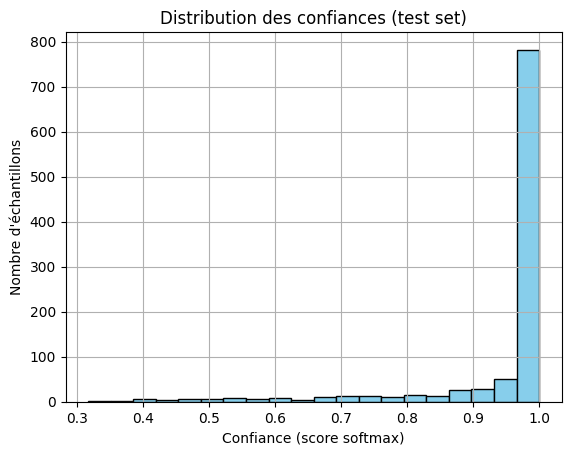

In [ ]:
confidences = []
corrects = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ts(images)
        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        confidences.extend(max_probs.cpu().numpy())
        corrects.extend((preds == labels).cpu().numpy())

confidences = np.array(confidences)
corrects = np.array(corrects)

# ---- Courbe globale
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des confiances (test set)")
plt.xlabel("Confiance (score softmax)")
plt.ylabel("Nombre d'échantillons")
plt.grid(True)
plt.show()

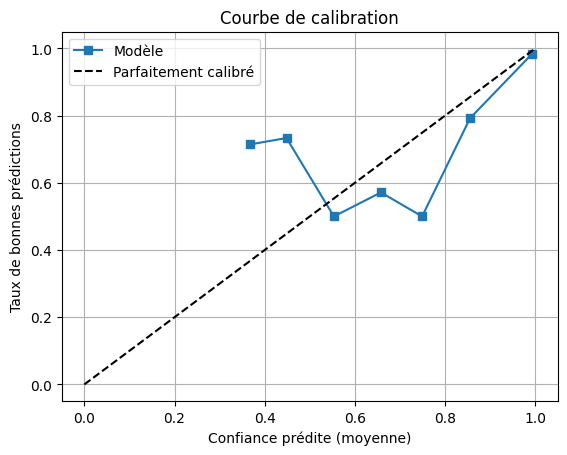

In [ ]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    corrects, confidences, n_bins=10
)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Modèle")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.xlabel("Confiance prédite (moyenne)")
plt.ylabel("Taux de bonnes prédictions")
plt.title("Courbe de calibration")
plt.legend()
plt.grid(True)
plt.show()


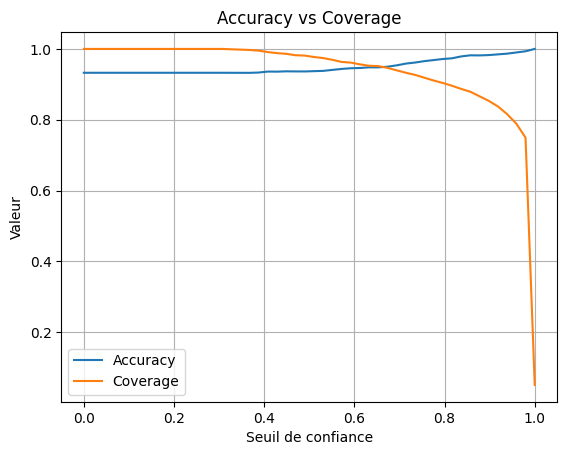

In [ ]:
thresholds = np.linspace(0, 1, 50)
accuracies = []
coverages = []

for t in thresholds:
    mask = confidences >= t
    if mask.sum() == 0:
        continue
    acc = corrects[mask].mean()
    accuracies.append(acc)
    coverages.append(mask.mean())

plt.plot(thresholds[:len(accuracies)], accuracies, label="Accuracy")
plt.plot(thresholds[:len(coverages)], coverages, label="Coverage")
plt.xlabel("Seuil de confiance")
plt.ylabel("Valeur")
plt.title("Accuracy vs Coverage")
plt.legend()
plt.grid(True)
plt.show()


### **V.4 Top-k Accuracies**

In [ ]:
top1_correct = 0
top2_correct = 0
top3_correct = 0
total = 0

inception_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_model(images)

        # Top-k predictions
        _, top3_preds = torch.topk(outputs, k=3, dim=1)  # top3 predictions
        total += labels.size(0)

        # Top-1
        top1_correct += (top3_preds[:, 0] == labels).sum().item()
        # Top-3
        top2_correct += sum([labels[i] in top3_preds[i, :2] for i in range(labels.size(0))])
        # Top-5
        top3_correct += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

        # # Enregistrement pour d'autres métriques éventuellement
        # y_pred_test.extend(top3_preds[:, 0].cpu().numpy())  # top-1 prediction
        # y_true_test.extend(labels.cpu().numpy())

# Affichage des résultats
print(f"Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"Top-2 Accuracy: {100 * top2_correct / total:.2f}%")
print(f"Top-3 Accuracy: {100 * top3_correct / total:.2f}%")


Top-1 Accuracy: 97.03%
Top-2 Accuracy: 98.93%
Top-3 Accuracy: 99.70%


## **VI. Ensemble Learning**

In [ ]:
model_efficientnet.load_state_dict(torch.load('/content/efficient_weights.pth'))


<All keys matched successfully>

In [ ]:

def ensemble_learning(model1, model2, model3, val_loader, test_loader, device):
    """
    Performs ensemble learning using two models, combining their predictions.

    Args:
        model1: The first model.
        model2: The second model.
        val_loader: DataLoader for the validation set.
        test_loader: DataLoader for the test set.
        device: The device to run the models on (e.g., 'cuda' or 'cpu').

    Returns:
        A dictionary containing the accuracy and confusion matrices for both
        the validation and test sets, using the ensemble prediction.
    """

    results = {}

    for loader_name, data_loader in [("val", val_loader), ("test", test_loader)]:
        y_pred_ensemble = []
        y_true = []

        # Set both models to evaluation mode
        model1.eval()
        model2.eval()
        model3.eval()

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)

                # Get predictions from both models
                outputs1 = model1(images)
                outputs2 = model2(images)
                outputs3 = model3(images)

                # Get predicted probabilities
                probs1 = torch.softmax(outputs1, dim=1)
                probs2 = torch.softmax(outputs2, dim=1)
                probs3 = torch.softmax(outputs3, dim=1)

                # Average the probabilities (you can experiment with other methods)
                avg_probs = (probs1 + probs2 + probs3) / 3

                # Get the ensemble prediction
                _, predicted_ensemble = torch.max(avg_probs, 1)

                y_pred_ensemble.extend(predicted_ensemble.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        accuracy = accuracy_score(y_true, y_pred_ensemble)
        cm = confusion_matrix(y_true, y_pred_ensemble)

        results[f"ensemble_{loader_name}_accuracy"] = accuracy
        results[f"ensemble_{loader_name}_cm"] = cm

    return results

In [ ]:
results = ensemble_learning(inception_model, model_efficientnet, resnet50_model ,val_loader, test_loader, device)

print("Ensemble Learning Results:")
print(f"Validation Accuracy: {results['ensemble_val_accuracy']:.4f}")
print(f"Test Accuracy: {results['ensemble_test_accuracy']:.4f}")
print("\nValidation Confusion Matrix:")
print(results['ensemble_val_cm'])
print("\nTest Confusion Matrix:")
print(results['ensemble_test_cm'])

Ensemble Learning Results:
Validation Accuracy: 0.9537
Test Accuracy: 0.9426

Validation Confusion Matrix:
[[357   1   5   7   6   1   2]
 [  1 144   1   3   1   0   1]
 [  2   5 367   2   2   1   1]
 [  0   1   2 232   3   0   0]
 [  9   3   2   2 375   0   6]
 [  0   0   1   0   1  13   1]
 [  1   2   0   1   1   0 117]]

Test Confusion Matrix:
[[111   1   1   1   3   0   0]
 [  1  44   3   0   1   0   0]
 [  0   1 117   1   3   0   0]
 [  1   0   0  75   1   0   0]
 [  6   0   2   0 132   0   0]
 [  0   0   1   1   1   2   4]
 [  0   0   0   0   0   0  61]]


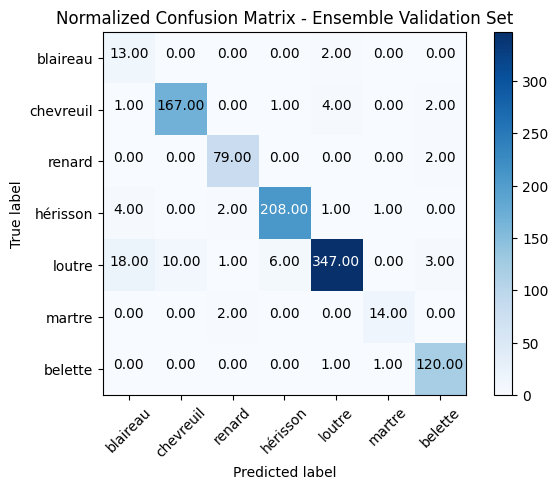

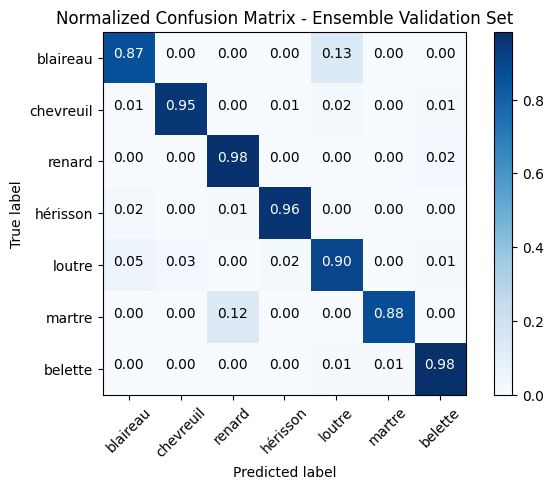

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix."""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage (replace with your actual data)
# Assuming results['ensemble_val_cm'] holds the confusion matrix and
# classes is your dictionary mapping class indices to class names

if 'ensemble_val_cm' in results:
    cm = results['ensemble_val_cm']
    plot_confusion_matrix(cm, classes.values(), title='Normalized Confusion Matrix - Ensemble Validation Set')
else:
  print("'ensemble_val_cm' key not found in the results dictionary")


#Normalize the confusion matrix
cm_normalized = cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, classes.values(), title='Normalized Confusion Matrix - Ensemble Validation Set')


In [ ]:
top2_correct_ensemble = 0
top3_correct_ensemble = 0
total_ensemble = 0

# Assuming 'test_loader' and 'device' are defined as in your original code

model_efficientnet.eval()
inception_model.eval()
resnet50_model.eval()

with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader for test set accuracy
        images, labels = images.to(device), labels.to(device)

        outputs1 = model_efficientnet(images)
        outputs2 = inception_model(images)
        outputs3 = resnet50_model(images)

        probs1 = torch.softmax(outputs1, dim=1)
        probs2 = torch.softmax(outputs2, dim=1)
        probs3 = torch.softmax(outputs3, dim=1)

        avg_probs = (probs1 + probs2 + probs3)/3
        _, top3_preds_ensemble = torch.topk(avg_probs, k=3, dim=1)
        total_ensemble += labels.size(0)

        top2_correct_ensemble += sum([labels[i] in top3_preds_ensemble[i, :2] for i in range(labels.size(0))])
        top3_correct_ensemble += sum([labels[i] in top3_preds_ensemble[i] for i in range(labels.size(0))])

print(f"Ensemble Top-2 Accuracy (Test Set): {100 * top2_correct_ensemble / total_ensemble:.2f}%")
print(f"Ensemble Top-3 Accuracy (Test Set): {100 * top3_correct_ensemble / total_ensemble:.2f}%")

Ensemble Top-2 Accuracy (Test Set): 98.91%
Ensemble Top-3 Accuracy (Test Set): 99.70%


## **VII. Grad-CAM**

Pour chacun des modèles développés, on a chercher à comprendre de quelles manières nos modèles différencient les animaux. Grad-CAM le permet. En effet, Grad-CAM affiche une heatmap (ou carte de chaleur), représentant l'importance de chaque partie de l'image sur sa prise de décision. Plus certains pattern sont proches du rouge, plus ils ont eu une place prépondérante dans la prédiction faite.

**EfficientNet**

Prediction: renard


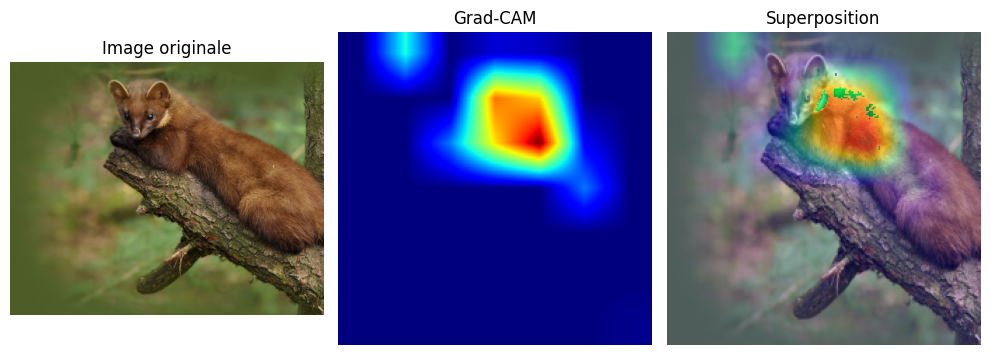

In [ ]:
features = None
gradients = None

def forward_hook(module, input, output):
    global features
    features = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Ici on prend le dernier bloc convolutif d’EfficientNet
target_layer = model_efficientnet.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# ---- 3. Image + preprocessing
img_path = "R.jpg"
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)


# Make a prediction
model_efficientnet.eval()
with torch.no_grad():
    output = model_efficientnet(input_tensor)
    _, predicted_class = torch.max(output, 1)
    predicted_label = classes[predicted_class.item()]

print(f"Prediction: {predicted_label}")

# ---- 4. Forward pass + backward pour Grad-CAM
output = model_efficientnet(input_tensor)
class_idx = output.argmax(dim=1).item()  # Classe prédite

# On calcule le gradient de la sortie par rapport aux features
model_efficientnet.zero_grad()
output[0, class_idx].backward()

# ---- 5. Calcul Grad-CAM
weights = gradients.mean(dim=(2, 3), keepdim=True)  # Moyenne des gradients
cam = (weights * features).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().cpu().detach().numpy()

# ---- 6. Normalisation + redimension
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# ---- 7. Superposition avec l’image originale
img_cv = cv2.cvtColor(np.array(image.resize((224, 224))), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img_cv

# ---- 8. Affichage
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Superposition")
plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


**ResNet50**

Prediction: belette


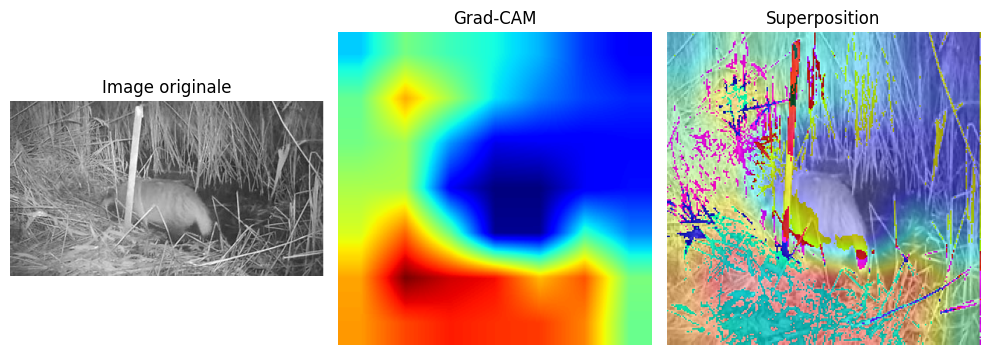

In [ ]:
# ---- 1. Initialisation
features = None
gradients = None

# ---- 2. Hooks sur la dernière couche convolutive de ResNet50
def forward_hook(module, input, output):
    global features
    features = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# ResNet50 : le dernier bloc convolutif est layer4[-1]
target_layer = resnet50_model.layer4[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# ---- 3. Image + prétraitement
img_path = "/content/OIP (10).jpg"
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)

# ---- 4. Prédiction
resnet50_model.eval()
with torch.no_grad():
    output = resnet50_model(input_tensor)
    _, predicted_class = torch.max(output, 1)
    predicted_label = classes[predicted_class.item()]  # suppose que tu as une liste `classes`

print(f"Prediction: {predicted_label}")

# ---- 5. Grad-CAM : forward + backward
output = resnet50_model(input_tensor)
class_idx = output.argmax(dim=1).item()

resnet50_model.zero_grad()
output[0, class_idx].backward()

# ---- 6. Calcul carte Grad-CAM
weights = gradients.mean(dim=(2, 3), keepdim=True)
cam = (weights * features).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().cpu().detach().numpy()
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# ---- 7. Superposition avec image
img_cv = cv2.cvtColor(np.array(image.resize((224, 224))), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img_cv

# ---- 8. Affichage
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Superposition")
plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

**Inception**

Top 3 prédictions :
1) mustelidé : 99.86%
2) blaireau : 0.14%
3) renard : 0.00%


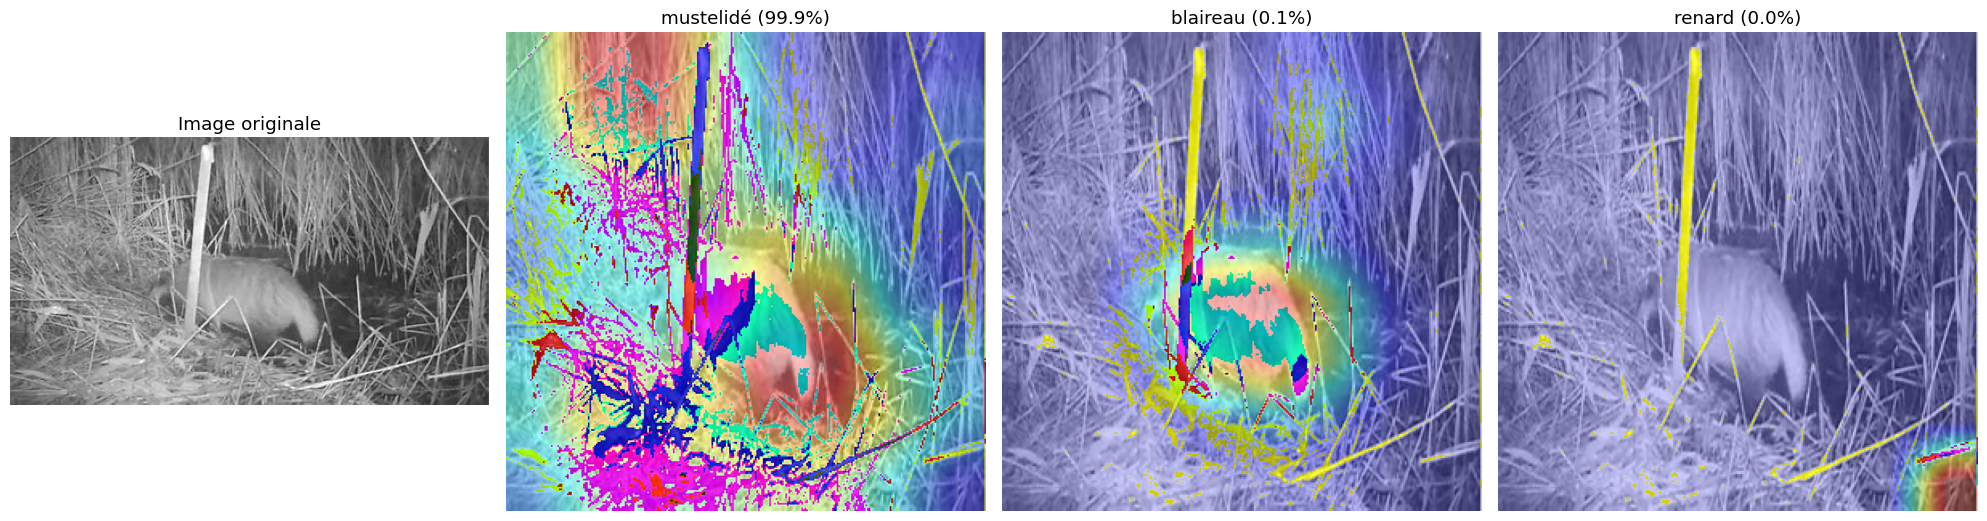

In [ ]:

# --- 1. Charger l’image
img_path = "/content/testDeepFaune/OIP (10).jpg"
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception attend 299x299
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# input_tensor_0 = transform(image).unsqueeze(0).to(device)
input_tensor = transform(image).unsqueeze(0).to(device)

# --- 2. Hooks pour Grad-CAM
features = None
gradients = None

def forward_hook(module, input, output):
    global features
    features = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook sur la dernière couche convolutive
target_layer = inception_model.Mixed_7c
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# --- 3. Prédiction + Top 3
inception_model.eval()
with torch.no_grad():
    output = inception_model(input_tensor)

# Attention : Inception retourne un tuple pendant l'entraînement (aux_logits, logits)
if isinstance(output, tuple):
    output = output[0]

probs = F.softmax(output.squeeze(), dim=0)
topk_probs, topk_indices = torch.topk(probs, k=3)

print("Top 3 prédictions :")
num_classes = output.shape[1] # The number of output classes of the model
for i in range(3):
    try:
        print(f"{i+1}) {classes[topk_indices[i].item()]} : {topk_probs[i]*100:.2f}%")
    except KeyError:
        print(f"{i+1}) Class {topk_indices[i].item()} (not in classes dict) : {topk_probs[i]*100:.2f}%")

# --- 4. Grad-CAM pour Top 3
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(image)
axs[0].set_title("Image originale")
axs[0].axis('off')

for i in range(3):
    class_idx = topk_indices[i].item()

    # Remettre à zéro gradients
    inception_model.zero_grad()

    # Refaire une passe pour backward
    output = inception_model(input_tensor)
    if isinstance(output, tuple):
        output = output[0]

    output[0, class_idx].backward(retain_graph=True)

    # Grad-CAM
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * features).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()
    cam = cv2.resize(cam, (299, 299))
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Superposition
    img_cv = cv2.cvtColor(np.array(image.resize((299, 299))), cv2.COLOR_RGB2BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img_cv
    superimposed_img = cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB)

    axs[i+1].imshow(superimposed_img)
    axs[i+1].set_title(f"{classes[class_idx]} ({topk_probs[i]*100:.1f}%)")
    axs[i+1].axis('off')

plt.tight_layout()
plt.show()


**ViT - DeepFaune**

Top 3 prédictions :
1) Classe 10 : 64.86%
2) Classe 11 : 11.09%
3) Classe 20 : 3.23%


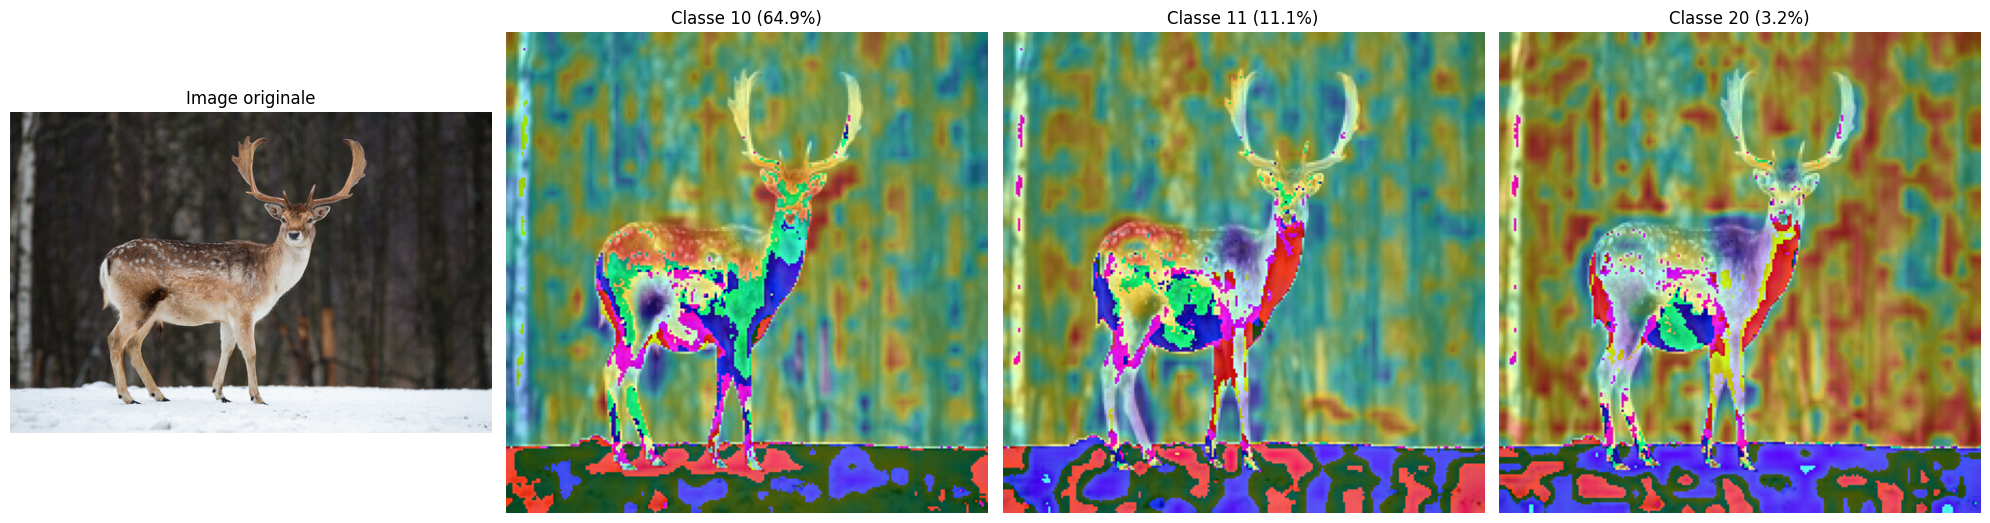

In [ ]:

classification_model.to(device).eval()

# --- Image
img_path = "/content/A-cervus-near-the-woods..jpg"
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((518, 518)),  # Inception attend 299x299
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)

# --- Grad-CAM: Hook sur la dernière couche attention ou patch embeddings
features = None
gradients = None

# Pour ViT, on hook l'output juste avant le head (norm layer ou dernier bloc)
def forward_hook(module, input, output):
    global features
    features = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Choisir une couche de la backbone
target_layer = classification_model.blocks[-1].norm1  # ou .attn si tu veux l'attention brute
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# --- Prédiction
with torch.no_grad():
    output = classification_model(input_tensor)

probs = F.softmax(output.squeeze(), dim=0)
topk_probs, topk_indices = torch.topk(probs, k=3)

# Définir les noms de classes
classes = {i: f"Classe {i}" for i in range(34)}

print("Top 3 prédictions :")
for i in range(3):
    class_id = topk_indices[i].item()
    print(f"{i+1}) {classes.get(class_id, f'Class {class_id}')} : {topk_probs[i]*100:.2f}%")

# --- Grad-CAM pour Top 3
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(image)
axs[0].set_title("Image originale")
axs[0].axis('off')

for i in range(3):
    class_idx = topk_indices[i].item()
    classification_model.zero_grad()

    # Refaire une passe pour backward
    output = classification_model(input_tensor)
    output[0, class_idx].backward(retain_graph=True)

    # Grad-CAM style ViT
    # features shape: (1, N, C), gradients: (1, N, C)
    grad = gradients[0]  # (N, C)
    fmap = features[0]   # (N, C)
    weights = grad.mean(dim=0)  # (C,)
    cam = torch.matmul(fmap, weights)  # (N,)
    cam = cam[1:]  # enlever le token CLS

    # Calculate the grid size based on the number of patches
    grid_size = int(np.sqrt(cam.shape[0]))

    cam = cam.reshape(grid_size, grid_size).detach().cpu().numpy()  # ViT patch size = 14x14 pour 224x224 image
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    # Superposition
    img_cv = cv2.cvtColor(np.array(image.resize((224, 224))), cv2.COLOR_RGB2BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img_cv
    superimposed_img = cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB)

    axs[i+1].imshow(superimposed_img)
    axs[i+1].set_title(f"{classes[class_idx]} ({topk_probs[i]*100:.1f}%)")
    axs[i+1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
wandb.init(project="Animal classification comparison")

In [ ]:
import wandb
import torch
from sklearn.metrics import classification_report
import numpy as np

def evaluate_model(model, test_loader, model_name, save_path):
    # 1. Initialisation wandb
    wandb.init(project="Animal classification comparison", name=model_name)
    wandb.watch(model, log="all")

    # Move the model to the specified device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 2. Passage en mode éval
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. Métriques
    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    wandb.log({
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1_score": report["weighted avg"]["f1-score"],
    })


    # 4. Sauvegarde des poids
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    torch.save(model.state_dict(), f"{save_path}/{model_name}.pt")
    wandb.save(f"{save_path}/{model_name}.pt")  # sauvegarde sur wandb

    wandb.finish()


In [ ]:
evaluate_model(model_efficientnet, test_loader, "EfficientNet", "models")
evaluate_model(inception_model, test_loader, "InceptionV3", "models")
evaluate_model(resnet50_model, test_loader, "ResNet50", "models")


In [ ]:

def save_dataloader_as_artifact(dataloader, name, split="train"):
    data_list = []
    label_list = []

    for inputs, labels in dataloader:
        data_list.append(inputs)
        label_list.append(labels)

    all_data = torch.cat(data_list)
    all_labels = torch.cat(label_list)

    # Sauvegarde en fichier .pt
    filename = f"{split}_data.pt"
    torch.save({'data': all_data, 'labels': all_labels}, filename)

    # Envoie sur wandb en tant qu'artifact
    artifact = wandb.Artifact(name, type='dataset')
    artifact.add_file(filename)
    wandb.log_artifact(artifact)

    print(f"{split} dataset enregistré sur wandb ✅")


In [ ]:
wandb.init(project="Animal classification comparison")

save_dataloader_as_artifact(train_loader, "train_set", "train")
save_dataloader_as_artifact(val_loader, "val_set", "val")
save_dataloader_as_artifact(test_loader, "test_set", "test")

wandb.finish()


train dataset enregistré sur wandb ✅
val dataset enregistré sur wandb ✅
test dataset enregistré sur wandb ✅
